# Credit Risk Model

## Importing Required Libraries

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                             roc_auc_score, roc_curve, precision_recall_curve, 
                             average_precision_score, log_loss, f1_score, 
                             matthews_corrcoef, make_scorer, fbeta_score, 
                             precision_score, recall_score)

## Loading the Data, along with Preparation for EDA

In [7]:
df = pd.read_csv(r"C:\Users\yashg\Downloads\german.data", 
                 delim_whitespace=True, header=None)

In [8]:
df.columns = [
    'ca_status', 'duration', 'cr_history', 'purpose', 'cr_amount', 'sav_acc',
    'emp_status', 'installment_rate', 'sex_marriage', 'guarantors',
    'residence_duration', 'property', 'age', 'installment_plan', 'housing',
    'existing_cr', 'job', 'dependents', 'telephone', 'foreign_worker', 'risk'
]

In [9]:
print("Missing values:", df.isnull().sum().sum())
print("Duplicate rows:", df.duplicated().sum())

Missing values: 0
Duplicate rows: 0


In [10]:
mappings = {
    'ca_status': {
        'A11': 'Negative balance', 'A12': 'Low balance (<200 DM)',
        'A13': 'High balance (≥200 DM)', 'A14': 'No account'
    },
    'cr_history': {
        'A30': 'No/All paid back duly', 'A31': 'All paid (same bank)',
        'A32': 'Existing credits paid back duly till now', 'A33': 'Delayed payments',
        'A34': 'Multiple existing credits'
    },
    'purpose': {
        'A40': 'Car (new)', 'A41': 'Car (used)', 'A42': 'Furniture/Equipment',
        'A43': 'Radio/Television', 'A44': 'Domestic Appliances', 'A45': 'Repairs',
        'A46': 'Education', 'A47': 'Vacation',
        'A48': 'Retraining', 'A49': 'Business', 'A410': 'Other'
    },
    'sav_acc': {
        'A61': 'None / <100 DM', 'A62': '100–500 DM', 'A63': '500–1000 DM',
        'A64': '>1000 DM', 'A65': 'Unknown/No Account'
    },
    'emp_status': {
        'A71': 'Unemployed', 'A72': '<1 year', 'A73': '1–4 years',
        'A74': '4–7 years', 'A75': '>7 years'
    },
    'sex_marriage': {
        'A91': 'M Divorced/Separated', 'A92': 'F Divorced/Seperated/Married',
        'A93': 'M Single', 'A94': 'M Married/Widowed',
        'A95': 'F Single'
    },
    'guarantors': {
        'A101': 'None', 'A102': 'Co-applicant', 'A103': 'Guarantor'
    },
    'property': {
        'A121': 'Real Estate', 'A122': 'BSSA/Life Insurance',
        'A123': 'Car/Other', 'A124': 'Unknown/None'
    },
    'installment_plan': {
        'A141': 'Bank', 'A142': 'Stores', 'A143': 'None'
    },
    'housing': {
        'A151': 'Rent', 'A152': 'Own', 'A153': 'Free'
    },
    'job': {
        'A171': 'Un-employed/skilled NR', 'A172': 'Unskilled R',
        'A173': 'Skilled', 'A174': 'Management Employee'
    },
    'telephone': {
        'A191': 'No', 'A192': 'Yes'
    },
    'foreign_worker': {
        'A201': 'Yes', 'A202': 'No'
    },
    'risk': {
        1: 0, 2: 1
    }
}

for col, mapping in mappings.items():
    df[col] = df[col].map(mapping)

## EDA

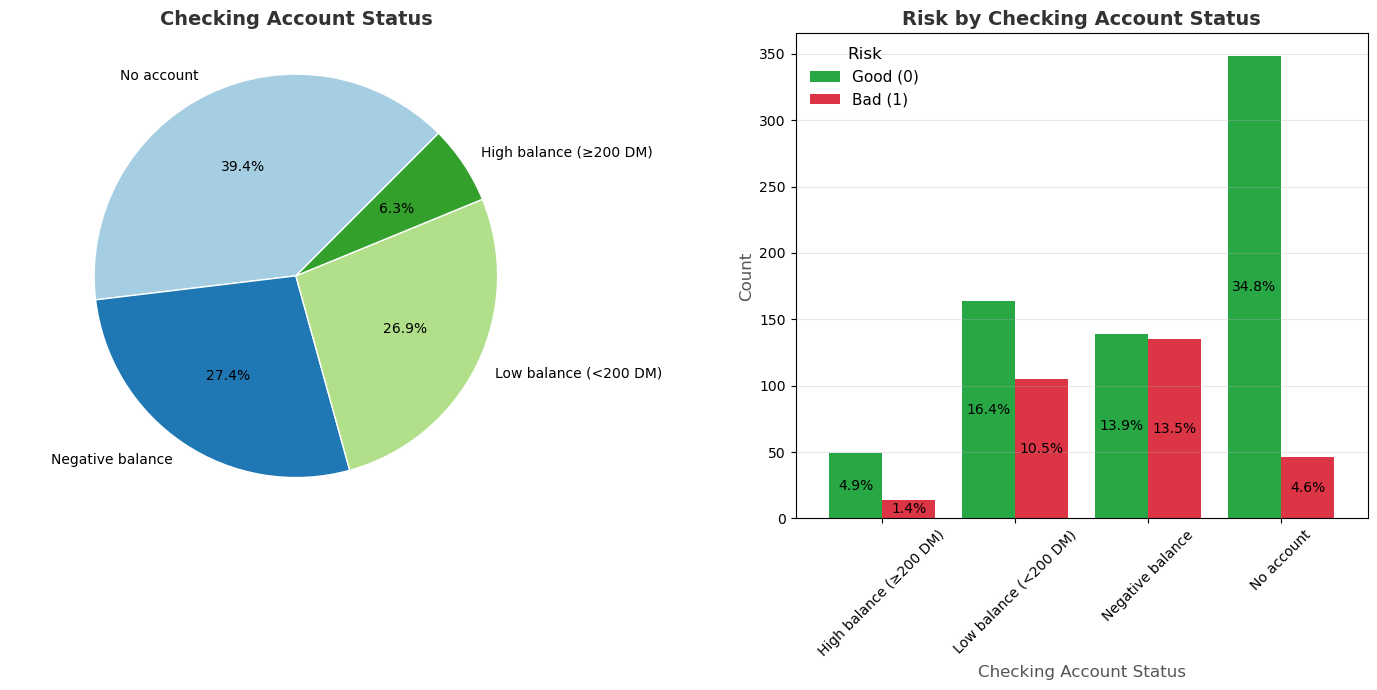

In [77]:
category_counts = df['ca_status'].value_counts()
category_percentages = category_counts / category_counts.sum() * 100

target_counts = pd.crosstab(df['ca_status'], df['risk'])

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

colors_pie = plt.cm.Paired(range(len(category_percentages)))
axes[0].pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=45, colors=colors_pie, wedgeprops={'edgecolor': 'white'})
axes[0].set_title('Checking Account Status', fontsize=14, fontweight='bold', color='#333333')
axes[0].axis('equal')

colors_bar = ['#28a745', '#dc3545']
bar_plot = target_counts.plot(kind='bar', ax=axes[1], color=colors_bar, width=0.8)

axes[1].set_title('Risk by Checking Account Status', fontsize=14, fontweight='bold', color='#333333')
axes[1].set_ylabel('Count', fontsize=12, color='#555555')
axes[1].set_xlabel('Checking Account Status', fontsize=12, color='#555555')
axes[1].legend(['Good (0)', 'Bad (1)'], title='Risk', fontsize=11, loc='upper left', title_fontsize=12, frameon=False, handlelength=2)
axes[1].grid(True, axis='y', linestyle='-', alpha=0.3)

for p in bar_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    
    if p.get_height() != 0:
        percentage = (height / target_counts.sum().sum()) * 100
        axes[1].text(x, y, f'{percentage:.1f}%', ha='center', va='center', color='black', fontsize=10)

# Rotate x-axis labels by 45 degrees
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

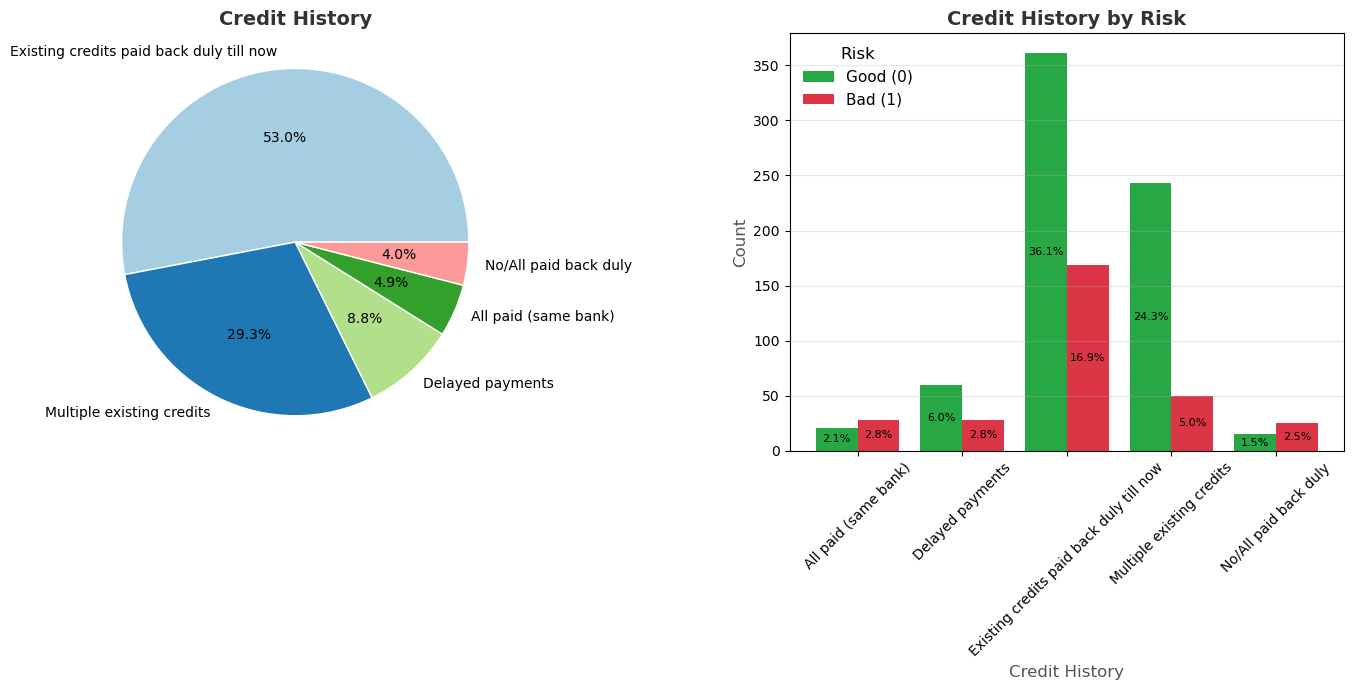

In [78]:
category_counts = df['cr_history'].value_counts()
category_percentages = category_counts / category_counts.sum() * 100

target_counts = pd.crosstab(df['cr_history'], df['risk'])

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

colors_pie = plt.cm.Paired(range(len(category_percentages)))
axes[0].pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=360, colors=colors_pie, wedgeprops={'edgecolor': 'white'})
axes[0].set_title('Credit History', fontsize=14, fontweight='bold', color='#333333')
axes[0].axis('equal')

colors_bar = ['#28a745', '#dc3545']
bar_plot = target_counts.plot(kind='bar', ax=axes[1], color=colors_bar, width=0.8)

axes[1].set_title('Credit History by Risk', fontsize=14, fontweight='bold', color='#333333')
axes[1].set_ylabel('Count', fontsize=12, color='#555555')
axes[1].set_xlabel('Credit History', fontsize=12, color='#555555')
axes[1].legend(['Good (0)', 'Bad (1)'], title='Risk', fontsize=11, loc='upper left', title_fontsize=12, frameon=False, handlelength=2)
axes[1].grid(True, axis='y', linestyle='-', alpha=0.3)

for p in bar_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    
    if p.get_height() != 0:
        percentage = (height / target_counts.sum().sum()) * 100
        axes[1].text(x, y, f'{percentage:.1f}%', ha='center', va='center', color='black', fontsize=8)

axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

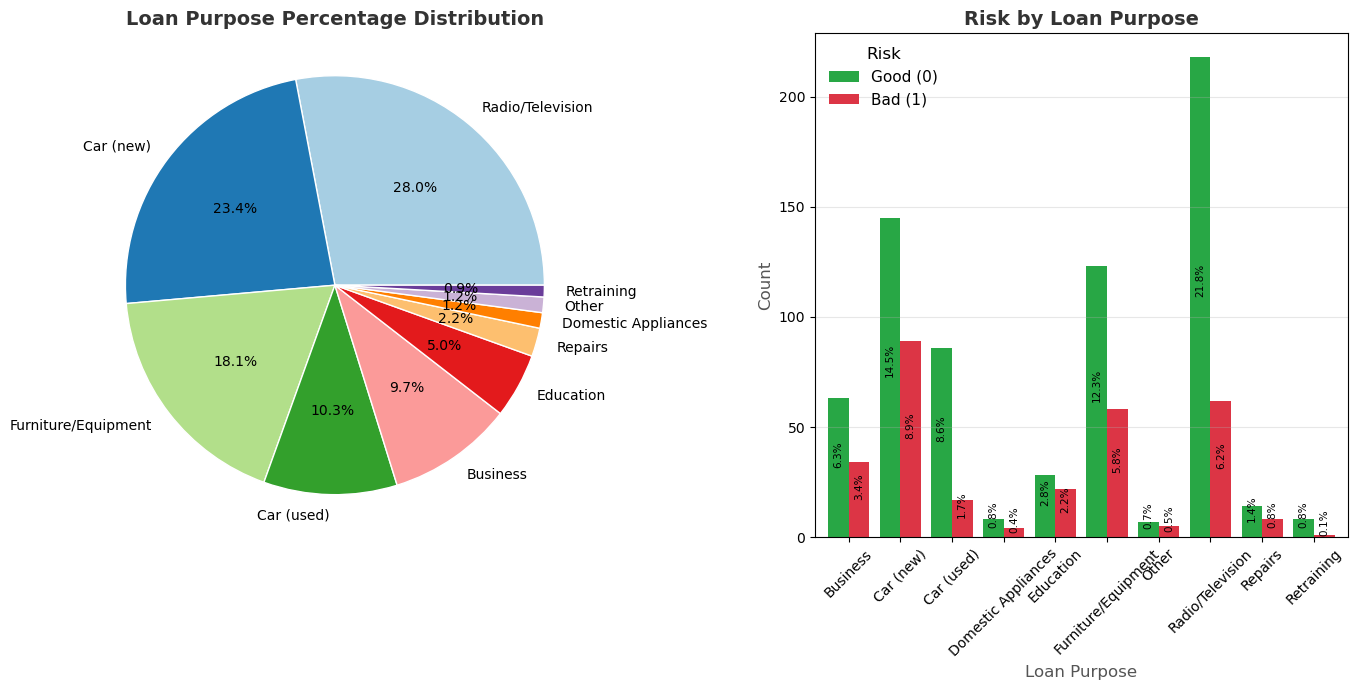

In [79]:
category_counts = df['purpose'].value_counts()
category_percentages = category_counts / category_counts.sum() * 100

target_counts = pd.crosstab(df['purpose'], df['risk'])

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

colors_pie = plt.cm.Paired(range(len(category_percentages)))
axes[0].pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=360, colors=colors_pie, wedgeprops={'edgecolor': 'white'})
axes[0].set_title('Loan Purpose Percentage Distribution', fontsize=14, fontweight='bold', color='#333333')
axes[0].axis('equal')

colors_bar = ['#28a745', '#dc3545']
bar_plot = target_counts.plot(kind='bar', ax=axes[1], color=colors_bar, width=0.8)

axes[1].set_title('Risk by Loan Purpose', fontsize=14, fontweight='bold', color='#333333')
axes[1].set_ylabel('Count', fontsize=12, color='#555555')
axes[1].set_xlabel('Loan Purpose', fontsize=12, color='#555555')
axes[1].legend(['Good (0)', 'Bad (1)'], title='Risk', fontsize=11, loc='upper left', title_fontsize=12, frameon=False, handlelength=2)
axes[1].grid(True, axis='y', linestyle='-', alpha=0.3)

for p in bar_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    
    if p.get_height() != 0:
        percentage = (height / target_counts.sum().sum()) * 100
        axes[1].text(x, y, f'{percentage:.1f}%', color='black', fontsize=7.5,ha='center',va='bottom',rotation=90)

axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

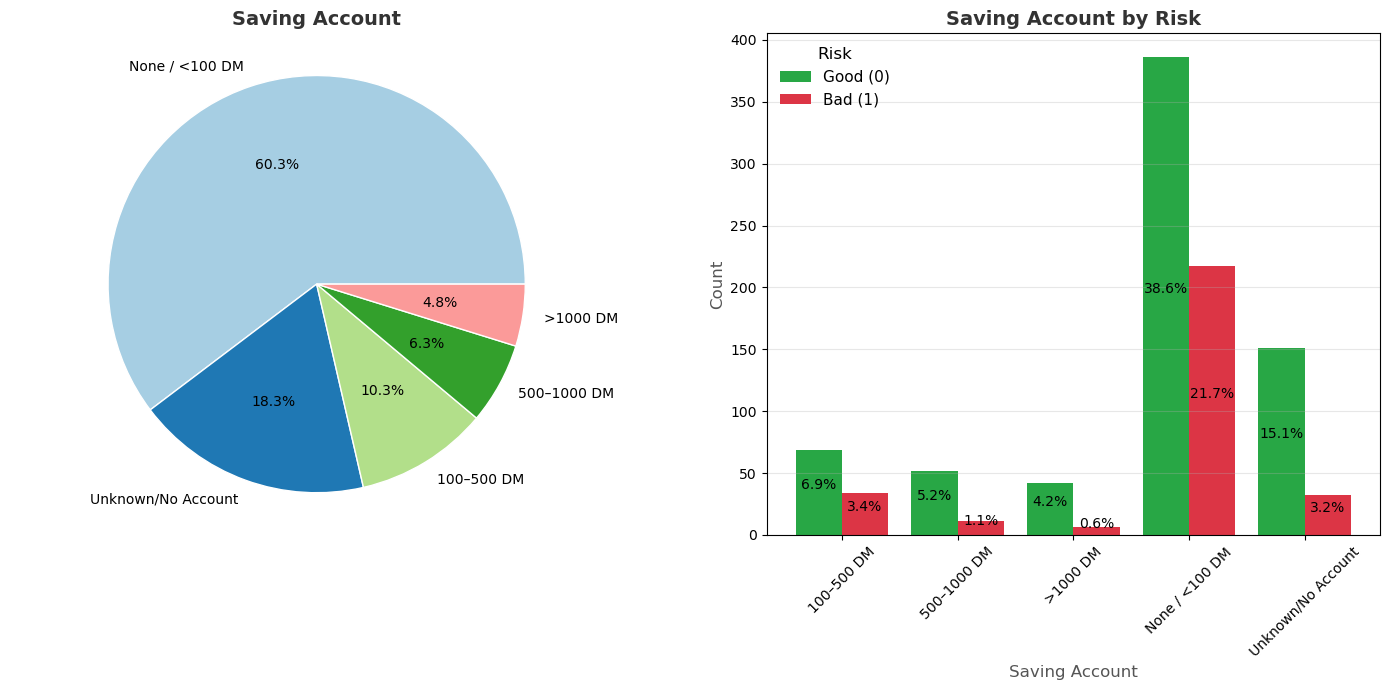

In [80]:
category_counts = df['sav_acc'].value_counts()
category_percentages = category_counts / category_counts.sum() * 100

target_counts = pd.crosstab(df['sav_acc'], df['risk'])

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

colors_pie = plt.cm.Paired(range(len(category_percentages)))
axes[0].pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=360, colors=colors_pie, wedgeprops={'edgecolor': 'white'})
axes[0].set_title('Saving Account', fontsize=14, fontweight='bold', color='#333333')
axes[0].axis('equal')

colors_bar = ['#28a745', '#dc3545']
bar_plot = target_counts.plot(kind='bar', ax=axes[1], color=colors_bar, width=0.8)

axes[1].set_title('Saving Account by Risk', fontsize=14, fontweight='bold', color='#333333')
axes[1].set_ylabel('Count', fontsize=12, color='#555555')
axes[1].set_xlabel('Saving Account', fontsize=12, color='#555555')
axes[1].legend(['Good (0)', 'Bad (1)'], title='Risk', fontsize=11, loc='upper left', title_fontsize=12, frameon=False, handlelength=2)
axes[1].grid(True, axis='y', linestyle='-', alpha=0.3)

for p in bar_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    
    if p.get_height() != 0:
        percentage = (height / target_counts.sum().sum()) * 100
        axes[1].text(x, y, f'{percentage:.1f}%', ha='center', va='bottom', color='black', fontsize=10)

axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

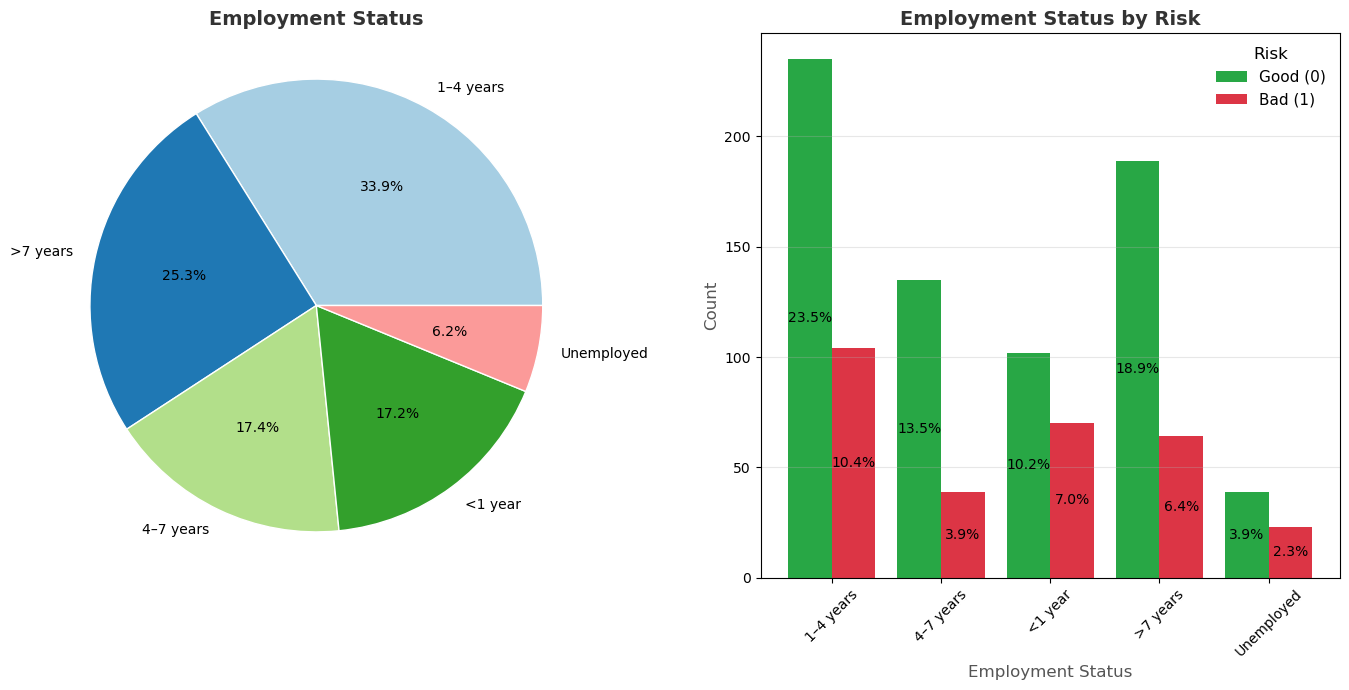

In [81]:
category_counts = df['emp_status'].value_counts()
category_percentages = category_counts / category_counts.sum() * 100

target_counts = pd.crosstab(df['emp_status'], df['risk'])

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

colors_pie = plt.cm.Paired(range(len(category_percentages)))
axes[0].pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=360, colors=colors_pie, wedgeprops={'edgecolor': 'white'})
axes[0].set_title('Employment Status', fontsize=14, fontweight='bold', color='#333333')
axes[0].axis('equal')

colors_bar = ['#28a745', '#dc3545']
bar_plot = target_counts.plot(kind='bar', ax=axes[1], color=colors_bar, width=0.8)

axes[1].set_title('Employment Status by Risk', fontsize=14, fontweight='bold', color='#333333')
axes[1].set_ylabel('Count', fontsize=12, color='#555555')
axes[1].set_xlabel('Employment Status', fontsize=12, color='#555555')
axes[1].legend(['Good (0)', 'Bad (1)'], title='Risk', fontsize=11, loc='upper right', title_fontsize=12, frameon=False, handlelength=2)
axes[1].grid(True, axis='y', linestyle='-', alpha=0.3)

for p in bar_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    
    if p.get_height() != 0:
        percentage = (height / target_counts.sum().sum()) * 100
        axes[1].text(x, y, f'{percentage:.1f}%', ha='center', va='center', color='black', fontsize=10)

axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

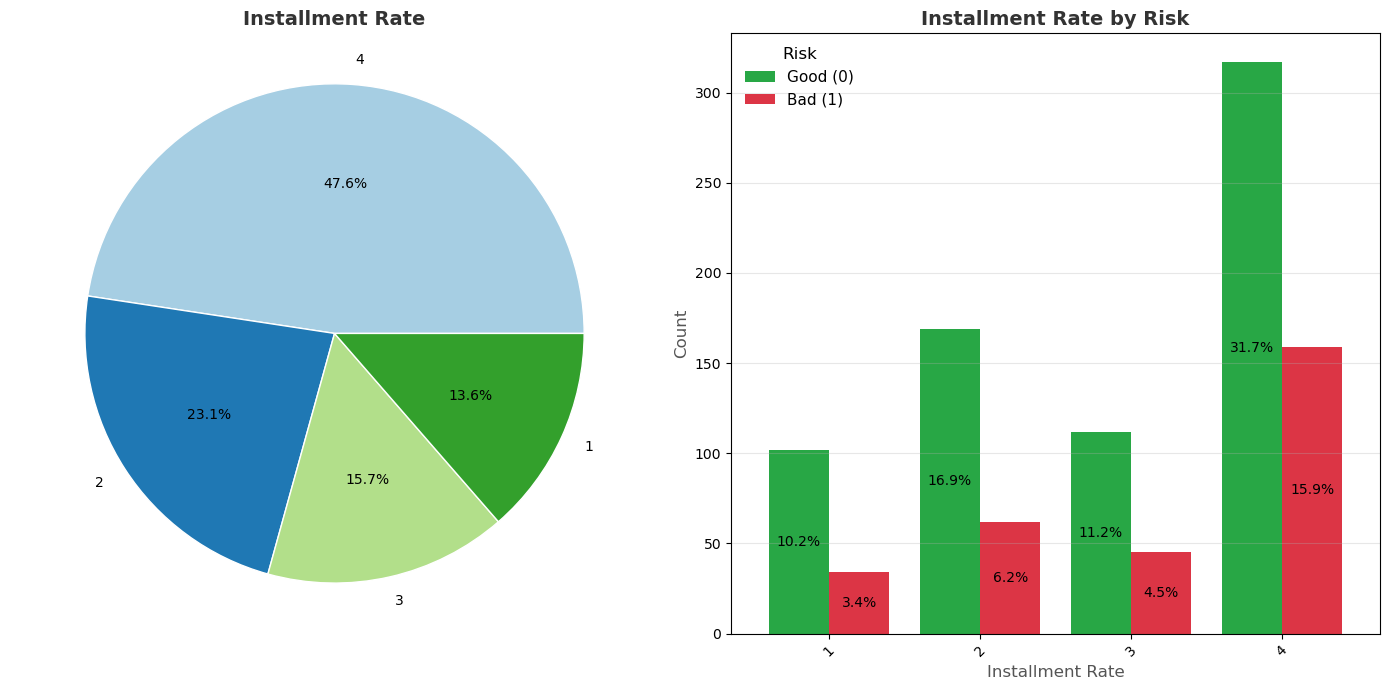

In [82]:
category_counts = df['installment_rate'].value_counts()
category_percentages = category_counts / category_counts.sum() * 100

target_counts = pd.crosstab(df['installment_rate'], df['risk'])

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

colors_pie = plt.cm.Paired(range(len(category_percentages)))
axes[0].pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=360, colors=colors_pie, wedgeprops={'edgecolor': 'white'})
axes[0].set_title('Installment Rate', fontsize=14, fontweight='bold', color='#333333')
axes[0].axis('equal')

colors_bar = ['#28a745', '#dc3545']
bar_plot = target_counts.plot(kind='bar', ax=axes[1], color=colors_bar, width=0.8)

axes[1].set_title('Installment Rate by Risk', fontsize=14, fontweight='bold', color='#333333')
axes[1].set_ylabel('Count', fontsize=12, color='#555555')
axes[1].set_xlabel('Installment Rate', fontsize=12, color='#555555')
axes[1].legend(['Good (0)', 'Bad (1)'], title='Risk', fontsize=11, loc='upper left', title_fontsize=12, frameon=False, handlelength=2)
axes[1].grid(True, axis='y', linestyle='-', alpha=0.3)

for p in bar_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    
    if p.get_height() != 0:
        percentage = (height / target_counts.sum().sum()) * 100
        axes[1].text(x, y, f'{percentage:.1f}%', ha='center', va='center', color='black', fontsize=10)

axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

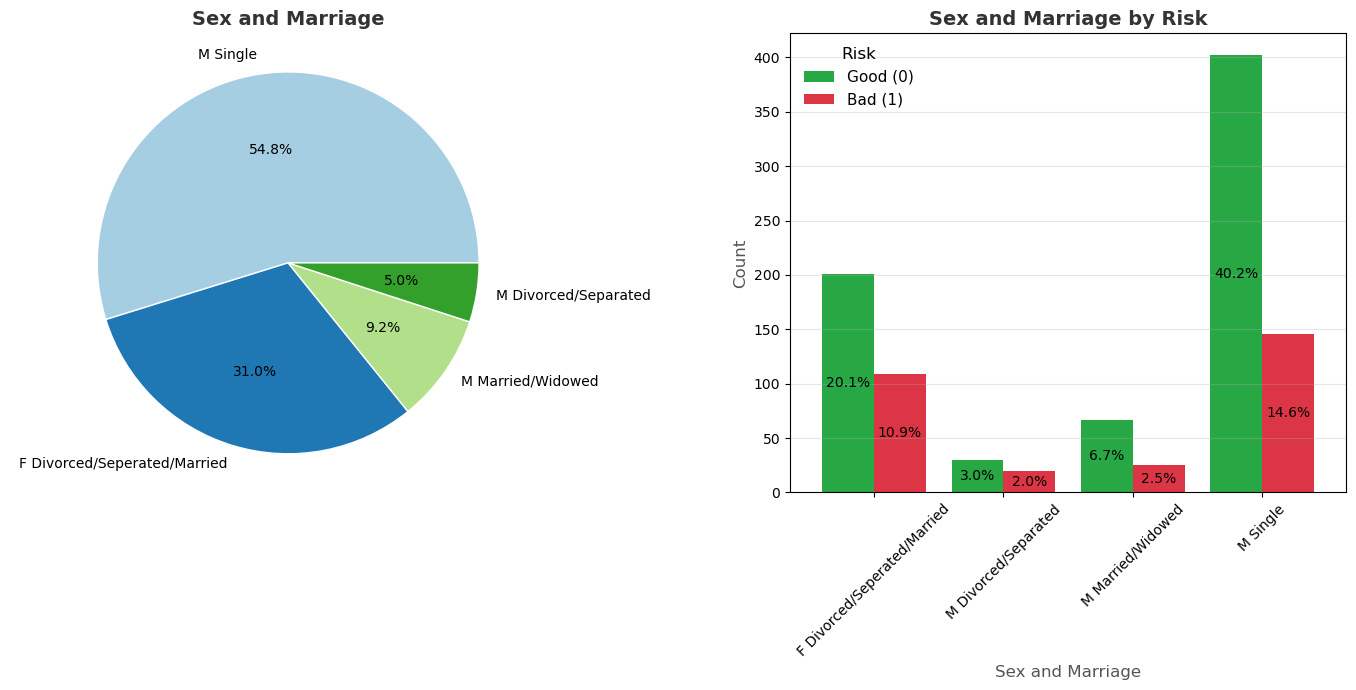

In [83]:
category_counts = df['sex_marriage'].value_counts()
category_percentages = category_counts / category_counts.sum() * 100

target_counts = pd.crosstab(df['sex_marriage'], df['risk'])

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

colors_pie = plt.cm.Paired(range(len(category_percentages)))
axes[0].pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=360, colors=colors_pie, wedgeprops={'edgecolor': 'white'})
axes[0].set_title('Sex and Marriage', fontsize=14, fontweight='bold', color='#333333')
axes[0].axis('equal')

colors_bar = ['#28a745', '#dc3545']
bar_plot = target_counts.plot(kind='bar', ax=axes[1], color=colors_bar, width=0.8)

axes[1].set_title('Sex and Marriage by Risk', fontsize=14, fontweight='bold', color='#333333')
axes[1].set_ylabel('Count', fontsize=12, color='#555555')
axes[1].set_xlabel('Sex and Marriage', fontsize=12, color='#555555')
axes[1].legend(['Good (0)', 'Bad (1)'], title='Risk', fontsize=11, loc='upper left', title_fontsize=12, frameon=False, handlelength=2)
axes[1].grid(True, axis='y', linestyle='-', alpha=0.3)

for p in bar_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    
    if p.get_height() != 0:
        percentage = (height / target_counts.sum().sum()) * 100
        axes[1].text(x, y, f'{percentage:.1f}%', ha='center', va='center', color='black', fontsize=10)

axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

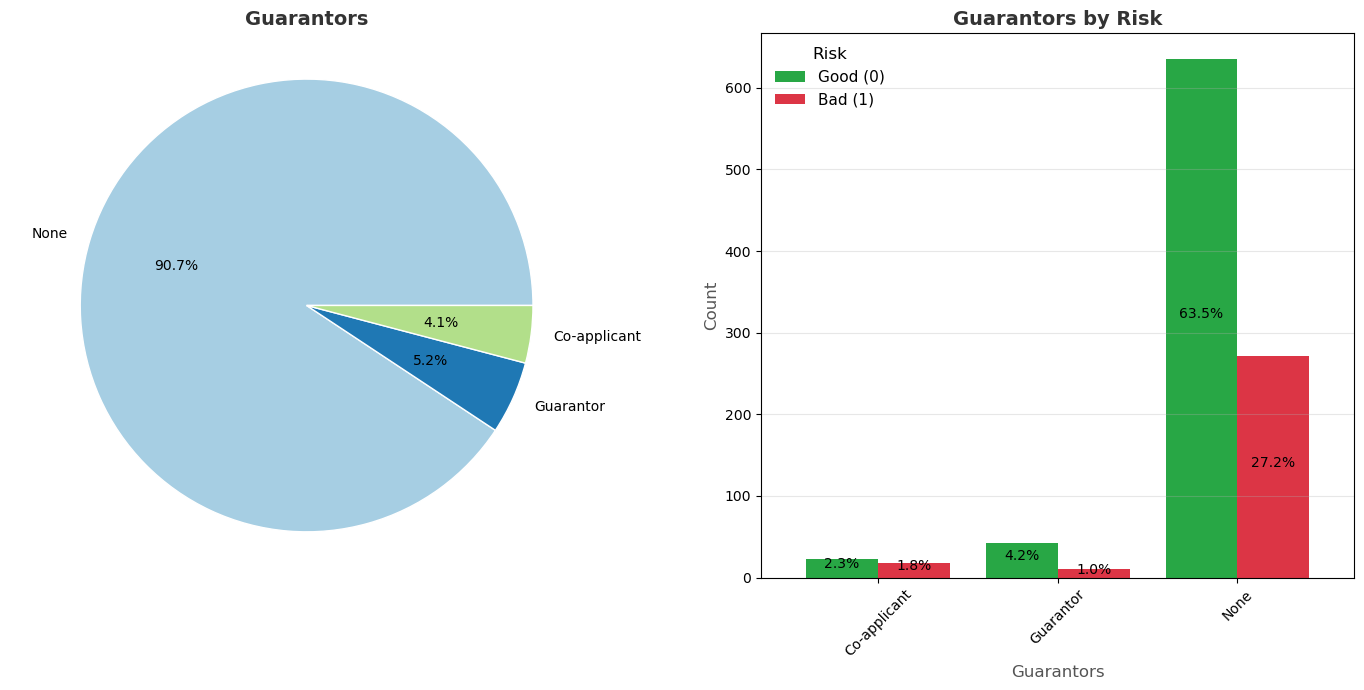

In [84]:
category_counts = df['guarantors'].value_counts()
category_percentages = category_counts / category_counts.sum() * 100

target_counts = pd.crosstab(df['guarantors'], df['risk'])

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

colors_pie = plt.cm.Paired(range(len(category_percentages)))
axes[0].pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=360, colors=colors_pie, wedgeprops={'edgecolor': 'white'})
axes[0].set_title('Guarantors', fontsize=14, fontweight='bold', color='#333333')
axes[0].axis('equal')

colors_bar = ['#28a745', '#dc3545']
bar_plot = target_counts.plot(kind='bar', ax=axes[1], color=colors_bar, width=0.8)

axes[1].set_title('Guarantors by Risk', fontsize=14, fontweight='bold', color='#333333')
axes[1].set_ylabel('Count', fontsize=12, color='#555555')
axes[1].set_xlabel('Guarantors', fontsize=12, color='#555555')
axes[1].legend(['Good (0)', 'Bad (1)'], title='Risk', fontsize=11, loc='upper left', title_fontsize=12, frameon=False, handlelength=2)
axes[1].grid(True, axis='y', linestyle='-', alpha=0.3)

for p in bar_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    
    if p.get_height() != 0:
        percentage = (height / target_counts.sum().sum()) * 100
        axes[1].text(x, y, f'{percentage:.1f}%', ha='center', va='baseline', color='black', fontsize=10,rotation=0)

axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

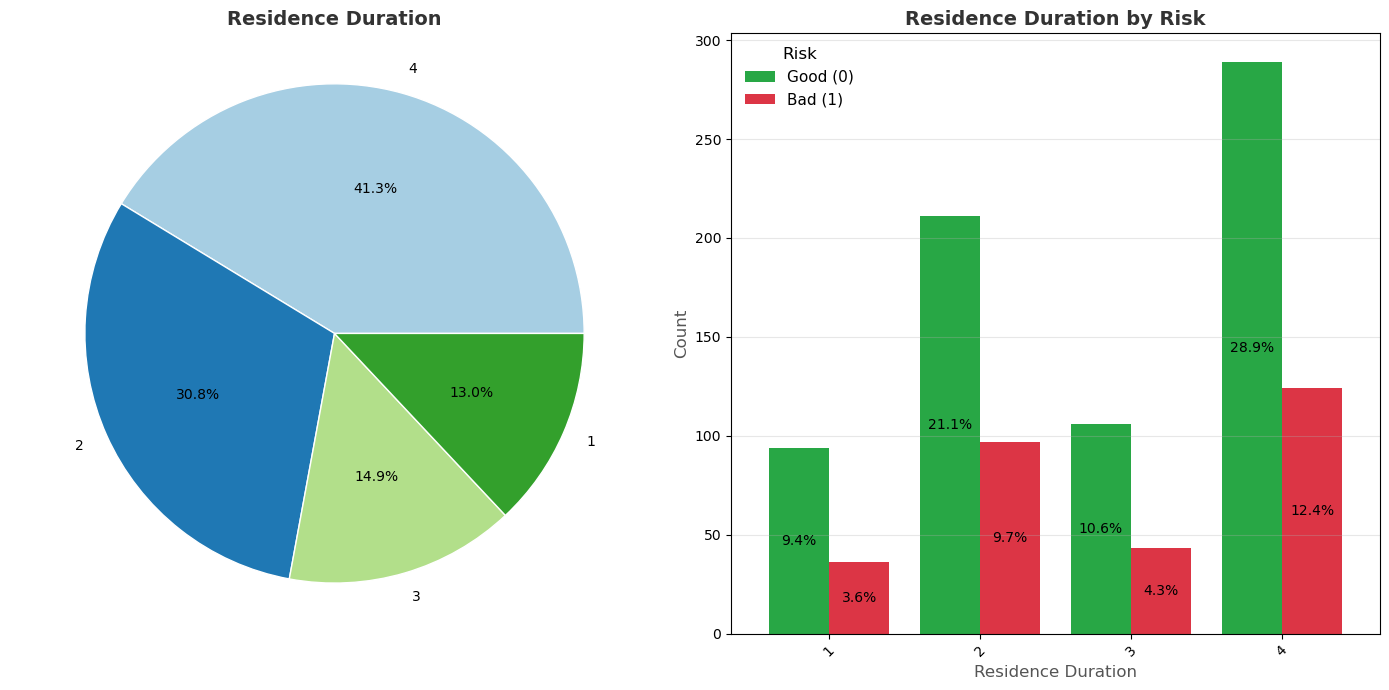

In [85]:
category_counts = df['residence_duration'].value_counts()
category_percentages = category_counts / category_counts.sum() * 100

target_counts = pd.crosstab(df['residence_duration'], df['risk'])

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

colors_pie = plt.cm.Paired(range(len(category_percentages)))
axes[0].pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=360, colors=colors_pie, wedgeprops={'edgecolor': 'white'})
axes[0].set_title('Residence Duration', fontsize=14, fontweight='bold', color='#333333')
axes[0].axis('equal')

colors_bar = ['#28a745', '#dc3545']
bar_plot = target_counts.plot(kind='bar', ax=axes[1], color=colors_bar, width=0.8)

axes[1].set_title('Residence Duration by Risk', fontsize=14, fontweight='bold', color='#333333')
axes[1].set_ylabel('Count', fontsize=12, color='#555555')
axes[1].set_xlabel('Residence Duration', fontsize=12, color='#555555')
axes[1].legend(['Good (0)', 'Bad (1)'], title='Risk', fontsize=11, loc='upper left', title_fontsize=12, frameon=False, handlelength=2)
axes[1].grid(True, axis='y', linestyle='-', alpha=0.3)

for p in bar_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    
    if p.get_height() != 0:
        percentage = (height / target_counts.sum().sum()) * 100
        axes[1].text(x, y, f'{percentage:.1f}%', ha='center', va='center', color='black', fontsize=10)

axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

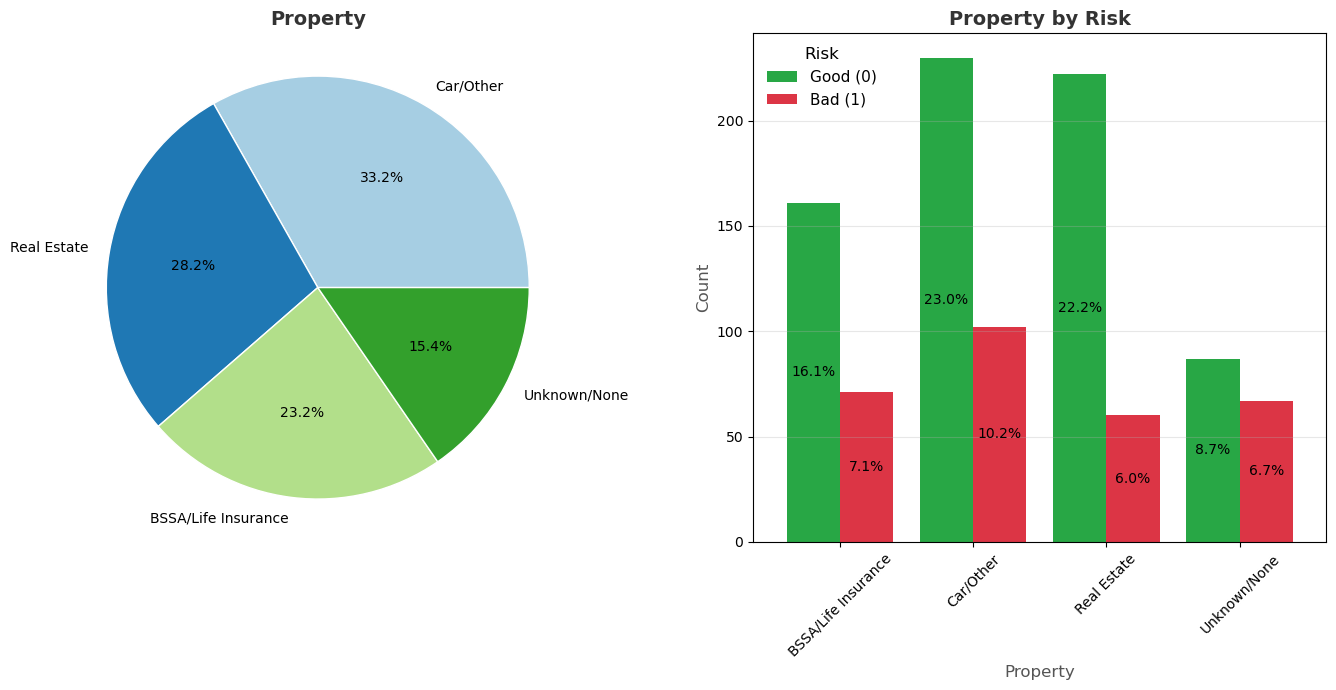

In [86]:
category_counts = df['property'].value_counts()
category_percentages = category_counts / category_counts.sum() * 100

target_counts = pd.crosstab(df['property'], df['risk'])

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

colors_pie = plt.cm.Paired(range(len(category_percentages)))
axes[0].pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=360, colors=colors_pie, wedgeprops={'edgecolor': 'white'})
axes[0].set_title('Property', fontsize=14, fontweight='bold', color='#333333')
axes[0].axis('equal')

colors_bar = ['#28a745', '#dc3545']
bar_plot = target_counts.plot(kind='bar', ax=axes[1], color=colors_bar, width=0.8)

axes[1].set_title('Property by Risk', fontsize=14, fontweight='bold', color='#333333')
axes[1].set_ylabel('Count', fontsize=12, color='#555555')
axes[1].set_xlabel('Property', fontsize=12, color='#555555')
axes[1].legend(['Good (0)', 'Bad (1)'], title='Risk', fontsize=11, loc='upper left', title_fontsize=12, frameon=False, handlelength=2)
axes[1].grid(True, axis='y', linestyle='-', alpha=0.3)

for p in bar_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    
    if p.get_height() != 0:
        percentage = (height / target_counts.sum().sum()) * 100
        axes[1].text(x, y, f'{percentage:.1f}%', ha='center', va='center', color='black', fontsize=10)

axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

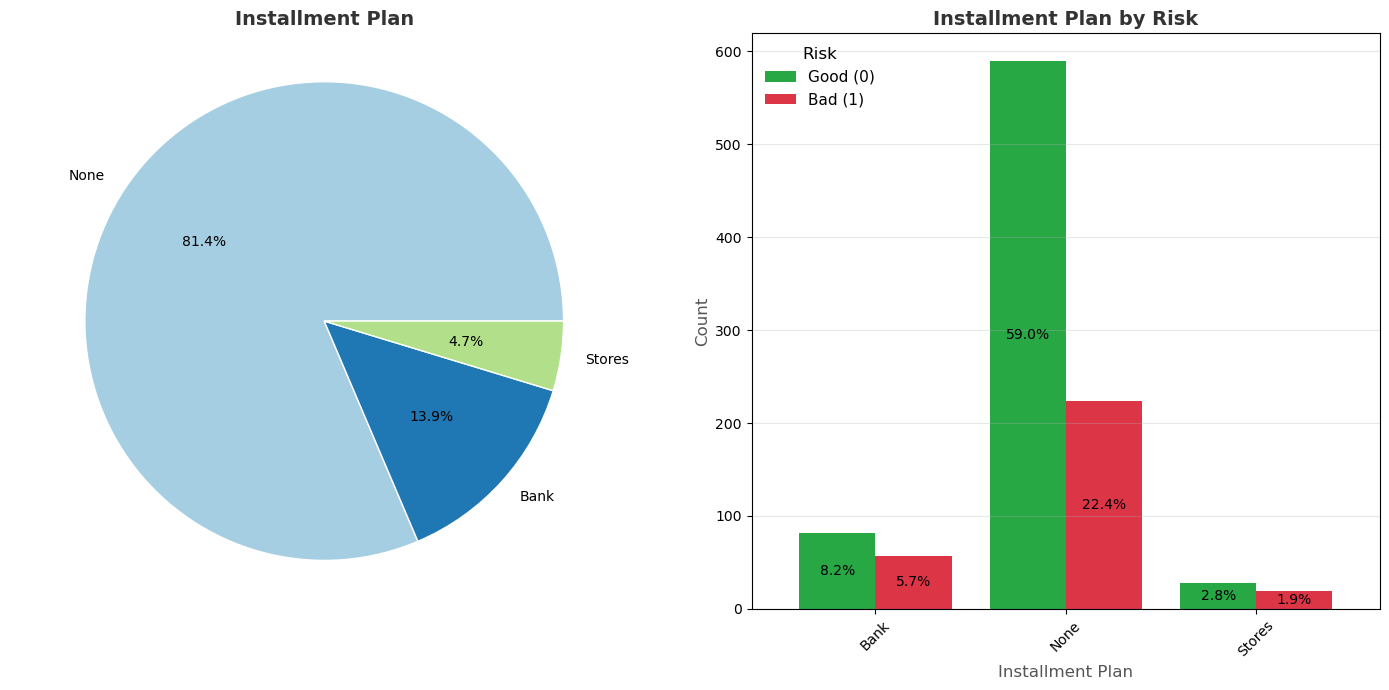

In [87]:
category_counts = df['installment_plan'].value_counts()
category_percentages = category_counts / category_counts.sum() * 100

target_counts = pd.crosstab(df['installment_plan'], df['risk'])

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

colors_pie = plt.cm.Paired(range(len(category_percentages)))
axes[0].pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=360, colors=colors_pie, wedgeprops={'edgecolor': 'white'})
axes[0].set_title('Installment Plan', fontsize=14, fontweight='bold', color='#333333')
axes[0].axis('equal')

colors_bar = ['#28a745', '#dc3545']
bar_plot = target_counts.plot(kind='bar', ax=axes[1], color=colors_bar, width=0.8)

axes[1].set_title('Installment Plan by Risk', fontsize=14, fontweight='bold', color='#333333')
axes[1].set_ylabel('Count', fontsize=12, color='#555555')
axes[1].set_xlabel('Installment Plan', fontsize=12, color='#555555')
axes[1].legend(['Good (0)', 'Bad (1)'], title='Risk', fontsize=11, loc='upper left', title_fontsize=12, frameon=False, handlelength=2)
axes[1].grid(True, axis='y', linestyle='-', alpha=0.3)

for p in bar_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    
    if p.get_height() != 0:
        percentage = (height / target_counts.sum().sum()) * 100
        axes[1].text(x, y, f'{percentage:.1f}%', ha='center', va='center', color='black', fontsize=10)

axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

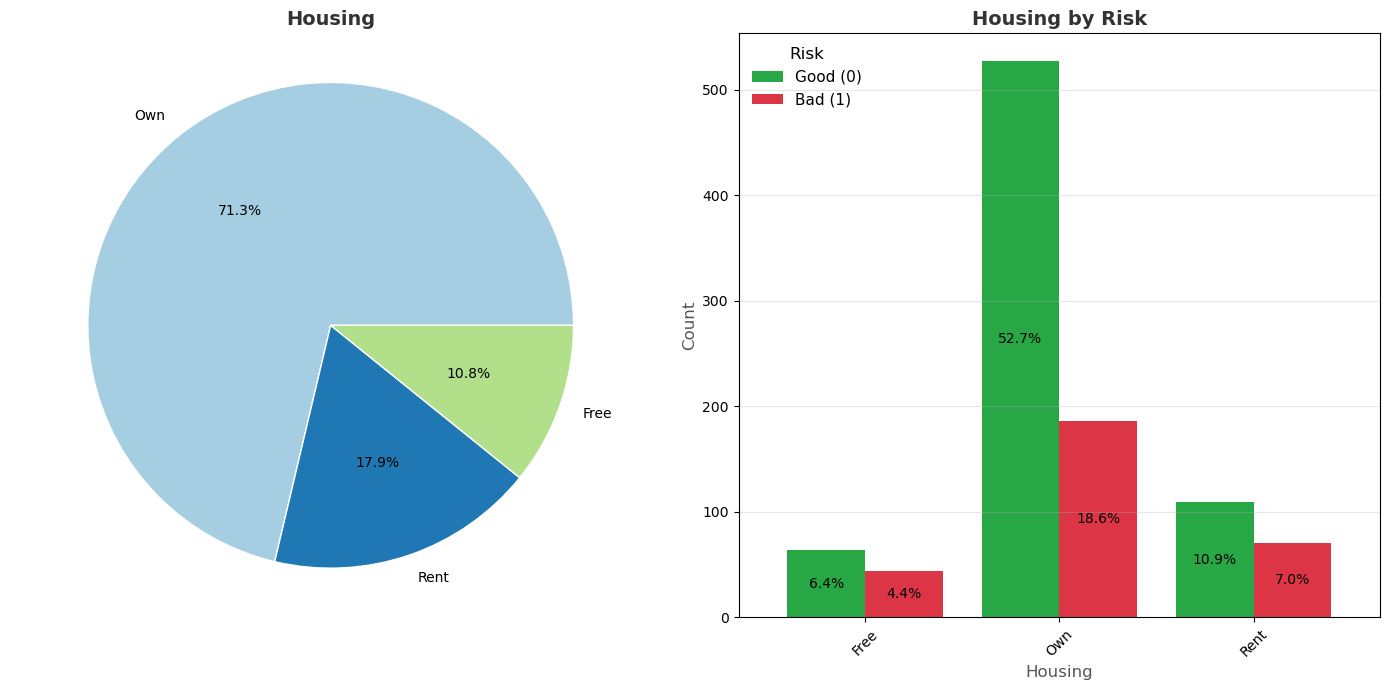

In [88]:
category_counts = df['housing'].value_counts()
category_percentages = category_counts / category_counts.sum() * 100

target_counts = pd.crosstab(df['housing'], df['risk'])

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

colors_pie = plt.cm.Paired(range(len(category_percentages)))
axes[0].pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=360, colors=colors_pie, wedgeprops={'edgecolor': 'white'})
axes[0].set_title('Housing', fontsize=14, fontweight='bold', color='#333333')
axes[0].axis('equal')

colors_bar = ['#28a745', '#dc3545']
bar_plot = target_counts.plot(kind='bar', ax=axes[1], color=colors_bar, width=0.8)

axes[1].set_title('Housing by Risk', fontsize=14, fontweight='bold', color='#333333')
axes[1].set_ylabel('Count', fontsize=12, color='#555555')
axes[1].set_xlabel('Housing', fontsize=12, color='#555555')
axes[1].legend(['Good (0)', 'Bad (1)'], title='Risk', fontsize=11, loc='upper left', title_fontsize=12, frameon=False, handlelength=2)
axes[1].grid(True, axis='y', linestyle='-', alpha=0.3)

for p in bar_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    
    if p.get_height() != 0:
        percentage = (height / target_counts.sum().sum()) * 100
        axes[1].text(x, y, f'{percentage:.1f}%', ha='center', va='center', color='black', fontsize=10)

axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

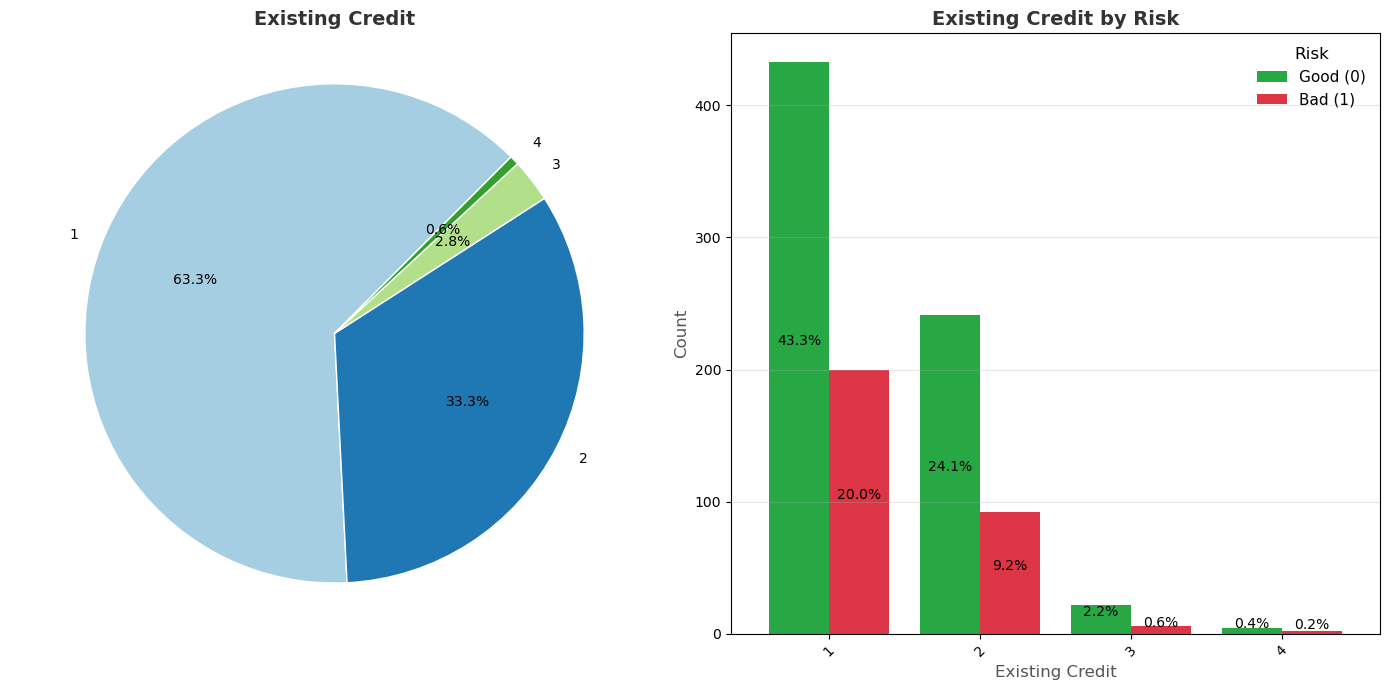

In [89]:
category_counts = df['existing_cr'].value_counts()
category_percentages = category_counts / category_counts.sum() * 100

target_counts = pd.crosstab(df['existing_cr'], df['risk'])

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

colors_pie = plt.cm.Paired(range(len(category_percentages)))
axes[0].pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=45, colors=colors_pie, wedgeprops={'edgecolor': 'white'})
axes[0].set_title('Existing Credit', fontsize=14, fontweight='bold', color='#333333')
axes[0].axis('equal')

colors_bar = ['#28a745', '#dc3545']
bar_plot = target_counts.plot(kind='bar', ax=axes[1], color=colors_bar, width=0.8)

axes[1].set_title('Existing Credit by Risk', fontsize=14, fontweight='bold', color='#333333')
axes[1].set_ylabel('Count', fontsize=12, color='#555555')
axes[1].set_xlabel('Existing Credit', fontsize=12, color='#555555')
axes[1].legend(['Good (0)', 'Bad (1)'], title='Risk', fontsize=11, loc='upper right', title_fontsize=12, frameon=False, handlelength=2)
axes[1].grid(True, axis='y', linestyle='-', alpha=0.3)

for p in bar_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    
    if p.get_height() != 0:
        percentage = (height / target_counts.sum().sum()) * 100
        axes[1].text(x, y, f'{percentage:.1f}%', ha='center', va='bottom', color='black', fontsize=10)

axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

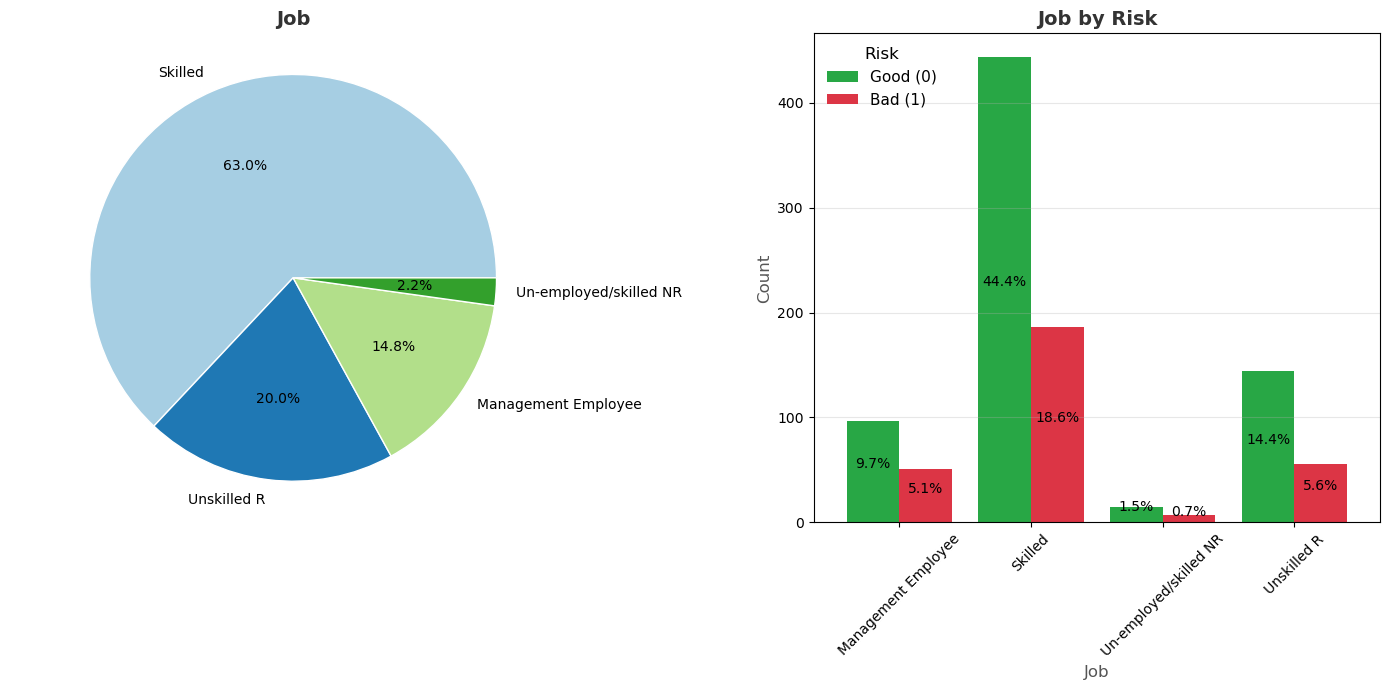

In [90]:
category_counts = df['job'].value_counts()
category_percentages = category_counts / category_counts.sum() * 100

target_counts = pd.crosstab(df['job'], df['risk'])

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

colors_pie = plt.cm.Paired(range(len(category_percentages)))
axes[0].pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=360, colors=colors_pie, wedgeprops={'edgecolor': 'white'})
axes[0].set_title('Job', fontsize=14, fontweight='bold', color='#333333')
axes[0].axis('equal')

colors_bar = ['#28a745', '#dc3545']
bar_plot = target_counts.plot(kind='bar', ax=axes[1], color=colors_bar, width=0.8)

axes[1].set_title('Job by Risk', fontsize=14, fontweight='bold', color='#333333')
axes[1].set_ylabel('Count', fontsize=12, color='#555555')
axes[1].set_xlabel('Job', fontsize=12, color='#555555')
axes[1].legend(['Good (0)', 'Bad (1)'], title='Risk', fontsize=11, loc='upper left', title_fontsize=12, frameon=False, handlelength=2)
axes[1].grid(True, axis='y', linestyle='-', alpha=0.3)

for p in bar_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    
    if p.get_height() != 0:
        percentage = (height / target_counts.sum().sum()) * 100
        axes[1].text(x, y, f'{percentage:.1f}%', ha='center', va='bottom', color='black', fontsize=10)

axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

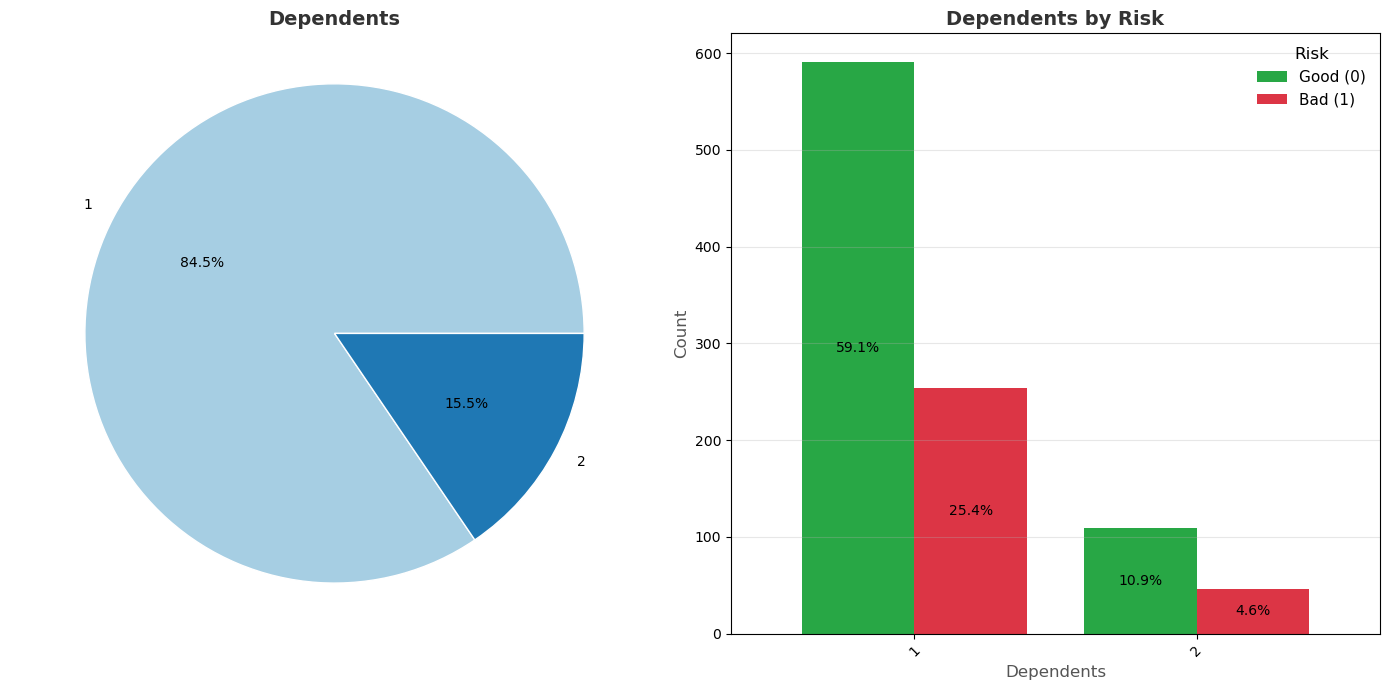

In [91]:
category_counts = df['dependents'].value_counts()
category_percentages = category_counts / category_counts.sum() * 100

target_counts = pd.crosstab(df['dependents'], df['risk'])

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

colors_pie = plt.cm.Paired(range(len(category_percentages)))
axes[0].pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=360, colors=colors_pie, wedgeprops={'edgecolor': 'white'})
axes[0].set_title('Dependents', fontsize=14, fontweight='bold', color='#333333')
axes[0].axis('equal')

colors_bar = ['#28a745', '#dc3545']
bar_plot = target_counts.plot(kind='bar', ax=axes[1], color=colors_bar, width=0.8)

axes[1].set_title('Dependents by Risk', fontsize=14, fontweight='bold', color='#333333')
axes[1].set_ylabel('Count', fontsize=12, color='#555555')
axes[1].set_xlabel('Dependents', fontsize=12, color='#555555')
axes[1].legend(['Good (0)', 'Bad (1)'], title='Risk', fontsize=11, loc='upper right', title_fontsize=12, frameon=False, handlelength=2)
axes[1].grid(True, axis='y', linestyle='-', alpha=0.3)

for p in bar_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    
    if p.get_height() != 0:
        percentage = (height / target_counts.sum().sum()) * 100
        axes[1].text(x, y, f'{percentage:.1f}%', ha='center', va='center', color='black', fontsize=10)

axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

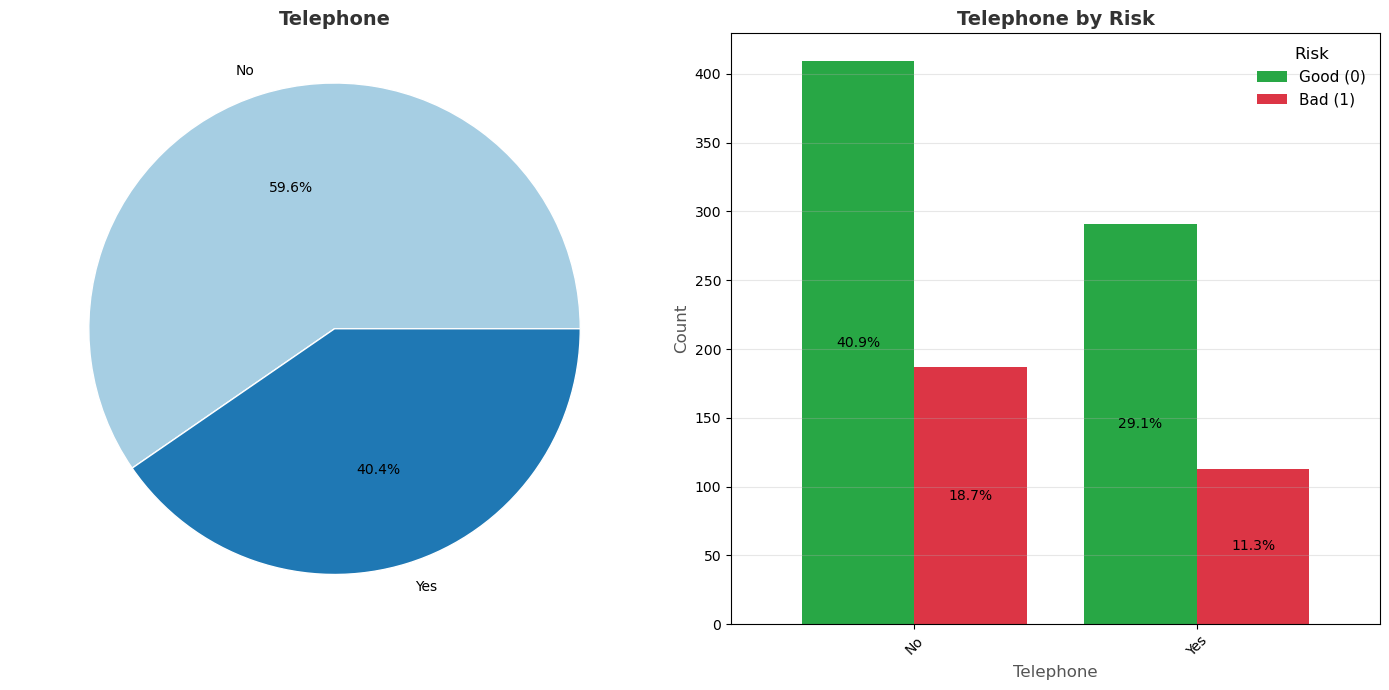

In [92]:
category_counts = df['telephone'].value_counts()
category_percentages = category_counts / category_counts.sum() * 100

target_counts = pd.crosstab(df['telephone'], df['risk'])

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

colors_pie = plt.cm.Paired(range(len(category_percentages)))
axes[0].pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=360, colors=colors_pie, wedgeprops={'edgecolor': 'white'})
axes[0].set_title('Telephone', fontsize=14, fontweight='bold', color='#333333')
axes[0].axis('equal')

colors_bar = ['#28a745', '#dc3545']
bar_plot = target_counts.plot(kind='bar', ax=axes[1], color=colors_bar, width=0.8)

axes[1].set_title('Telephone by Risk', fontsize=14, fontweight='bold', color='#333333')
axes[1].set_ylabel('Count', fontsize=12, color='#555555')
axes[1].set_xlabel('Telephone', fontsize=12, color='#555555')
axes[1].legend(['Good (0)', 'Bad (1)'], title='Risk', fontsize=11, loc='upper right', title_fontsize=12, frameon=False, handlelength=2)
axes[1].grid(True, axis='y', linestyle='-', alpha=0.3)

for p in bar_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    
    if p.get_height() != 0:
        percentage = (height / target_counts.sum().sum()) * 100
        axes[1].text(x, y, f'{percentage:.1f}%', ha='center', va='center', color='black', fontsize=10)

axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

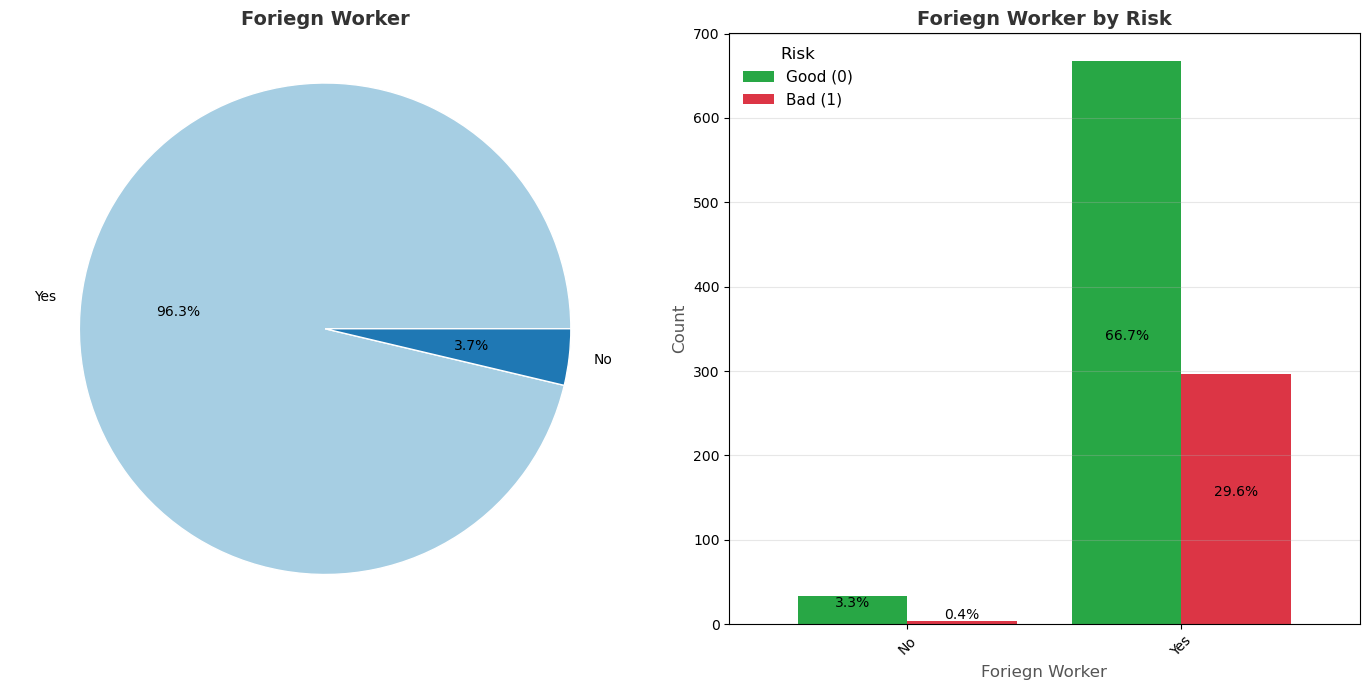

In [93]:
category_counts = df['foreign_worker'].value_counts()
category_percentages = category_counts / category_counts.sum() * 100

target_counts = pd.crosstab(df['foreign_worker'], df['risk'])

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

colors_pie = plt.cm.Paired(range(len(category_percentages)))
axes[0].pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=360, colors=colors_pie, wedgeprops={'edgecolor': 'white'})
axes[0].set_title('Foriegn Worker', fontsize=14, fontweight='bold', color='#333333')
axes[0].axis('equal')

colors_bar = ['#28a745', '#dc3545']
bar_plot = target_counts.plot(kind='bar', ax=axes[1], color=colors_bar, width=0.8)

axes[1].set_title('Foriegn Worker by Risk', fontsize=14, fontweight='bold', color='#333333')
axes[1].set_ylabel('Count', fontsize=12, color='#555555')
axes[1].set_xlabel('Foriegn Worker', fontsize=12, color='#555555')
axes[1].legend(['Good (0)', 'Bad (1)'], title='Risk', fontsize=11, loc='upper left', title_fontsize=12, frameon=False, handlelength=2)
axes[1].grid(True, axis='y', linestyle='-', alpha=0.3)

for p in bar_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    
    if p.get_height() != 0:
        percentage = (height / target_counts.sum().sum()) * 100
        axes[1].text(x, y, f'{percentage:.1f}%', ha='center', va='bottom', color='black', fontsize=10,rotation=0)

axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

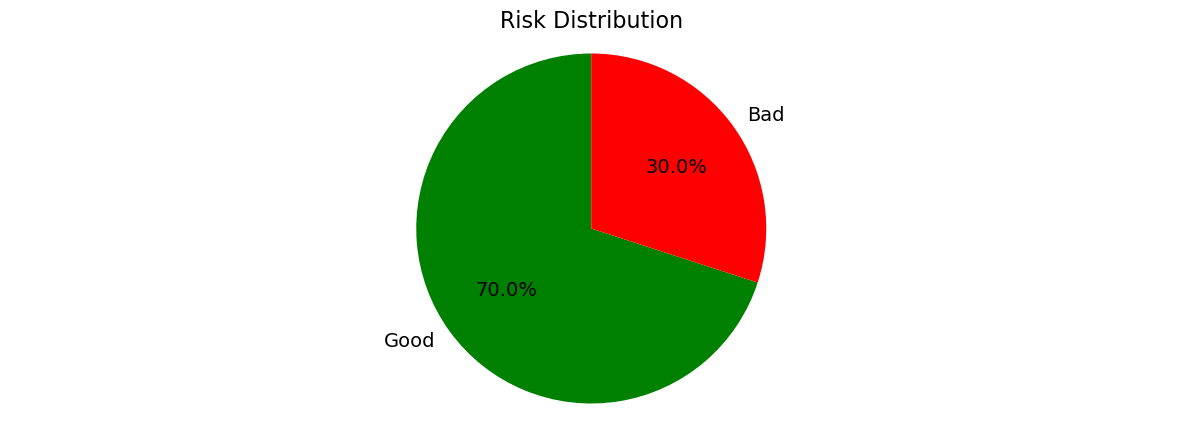

In [94]:
risk_counts = df['risk'].value_counts()

labels = ['Good', 'Bad']
sizes = [risk_counts.get(0, 0), risk_counts.get(1, 0)]
colors = ['green', 'red']

plt.figure(figsize=(15, 5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14})

plt.axis('equal')

plt.title("Risk Distribution", fontsize=16)
plt.show()

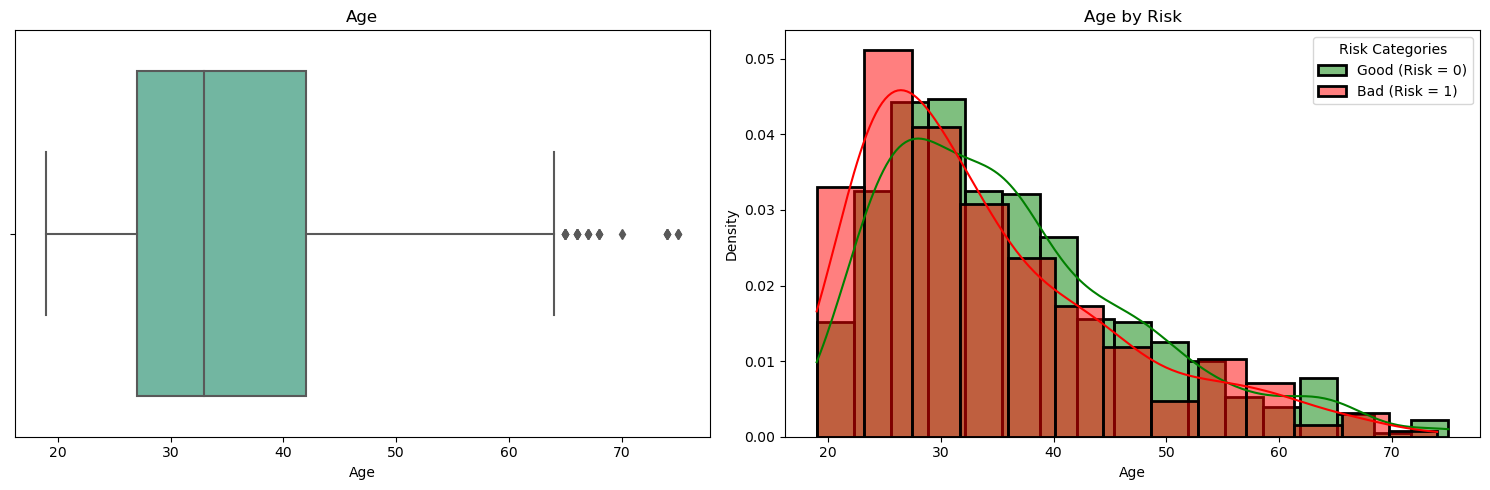

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=df, x='age', orient='h', ax=axes[0], palette="Set2")
axes[0].set_title("Age")
axes[0].set_xlabel("Age")

sns.histplot(data=df[df['risk'] == 0], x='age', kde=True, color='green', ax=axes[1], label='Good (Risk = 0)', stat="density", linewidth=2)
sns.histplot(data=df[df['risk'] == 1], x='age', kde=True, color='red', ax=axes[1], label='Bad (Risk = 1)', stat="density", linewidth=2)
axes[1].set_title("Age by Risk")
axes[1].set_xlabel("Age")
axes[1].set_ylabel("Density")
axes[1].legend(title="Risk Categories")

plt.tight_layout()
plt.show()

In [96]:
bins = [18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75]

labels = ['18-21', '21-24', '24-27', '27-30', '30-33', '33-36', '36-39', '39-42', 
          '42-45', '45-48', '48-51', '51-54', '54-57', '57-60', '60-63', '63-66', 
          '66-69', '69-72', '72-75']

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

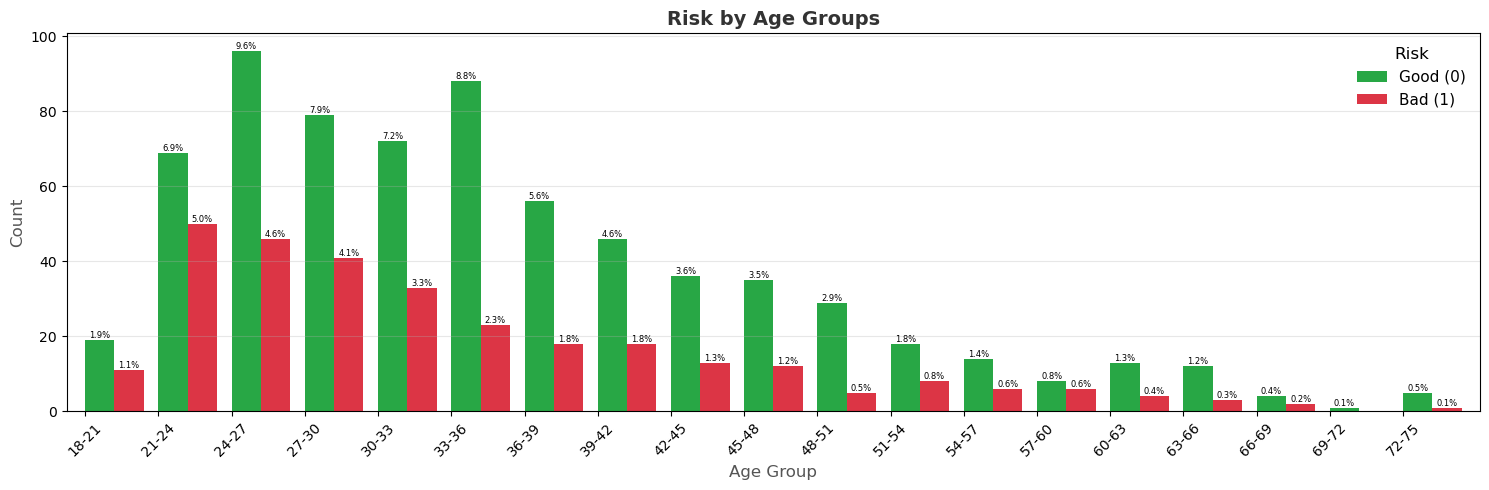

In [97]:
target_counts = pd.crosstab(df['age_group'], df['risk'])

fig, ax = plt.subplots(figsize=(15, 5))

colors_bar = ['#28a745', '#dc3545']  
bar_plot = target_counts.plot(kind='bar', ax=ax, color=colors_bar, width=0.8, position=0)

ax.set_title('Risk by Age Groups', fontsize=14, fontweight='bold', color='#333333')
ax.set_ylabel('Count', fontsize=12, color='#555555')
ax.set_xlabel('Age Group', fontsize=12, color='#555555')
ax.legend(['Good (0)', 'Bad (1)'], title='Risk', fontsize=11, loc='upper right', title_fontsize=12, frameon=False, handlelength=2)
ax.grid(True, axis='y', linestyle='-', alpha=0.3)

for p in bar_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height
    
    if height != 0:
        percentage = (height / target_counts.sum().sum()) * 100
        ax.text(x, y, f'{percentage:.1f}%', ha='center', va='bottom', color='black', fontsize=6, rotation=0)

ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


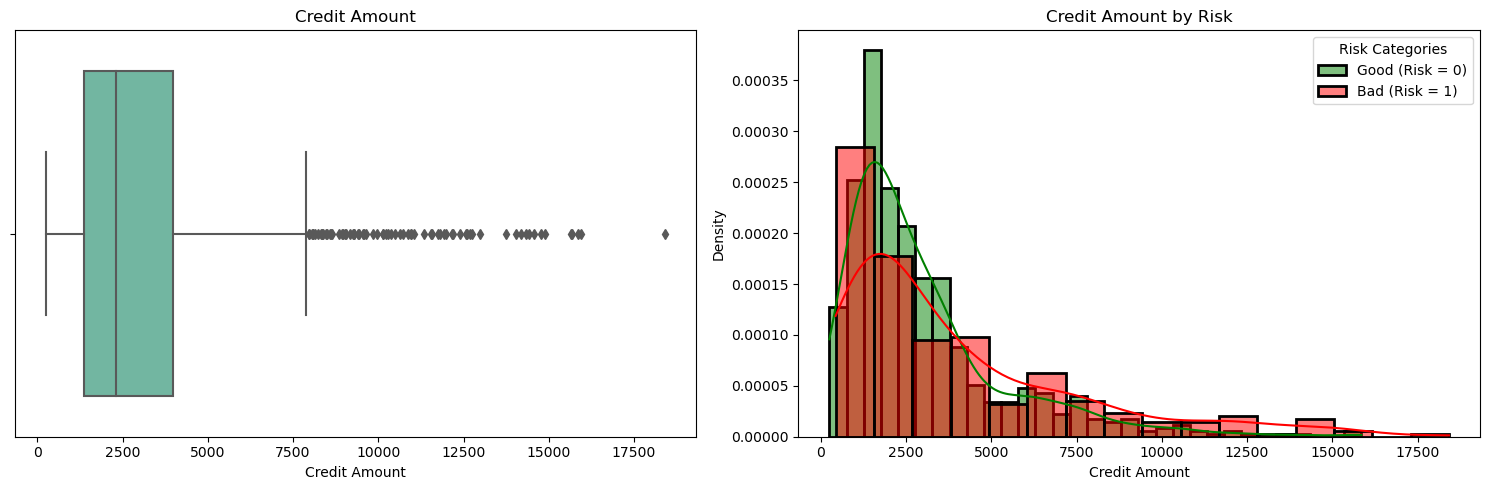

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=df, x='cr_amount', orient='h', ax=axes[0], palette="Set2")
axes[0].set_title("Credit Amount")
axes[0].set_xlabel("Credit Amount")

sns.histplot(data=df[df['risk'] == 0], x='cr_amount', kde=True, color='green', ax=axes[1], label='Good (Risk = 0)', stat="density", linewidth=2)
sns.histplot(data=df[df['risk'] == 1], x='cr_amount', kde=True, color='red', ax=axes[1], label='Bad (Risk = 1)', stat="density", linewidth=2)
axes[1].set_title("Credit Amount by Risk")
axes[1].set_xlabel("Credit Amount")
axes[1].set_ylabel("Density")
axes[1].legend(title="Risk Categories")

plt.tight_layout()
plt.show()

In [99]:
bins_cr_amount = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 
                  10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 
                  18000, 19000]

labels_cr_amount = ['0-1000', '1000-2000', '2000-3000', '3000-4000', '4000-5000', 
                    '5000-6000', '6000-7000', '7000-8000', '8000-9000', '9000-10000', 
                    '10000-11000', '11000-12000', '12000-13000', '13000-14000', 
                    '14000-15000', '15000-16000', '16000-17000', '17000-18000', 
                    '18000-19000']

df['cr_amount_group'] = pd.cut(df['cr_amount'], bins=bins_cr_amount, labels=labels_cr_amount, right=True)

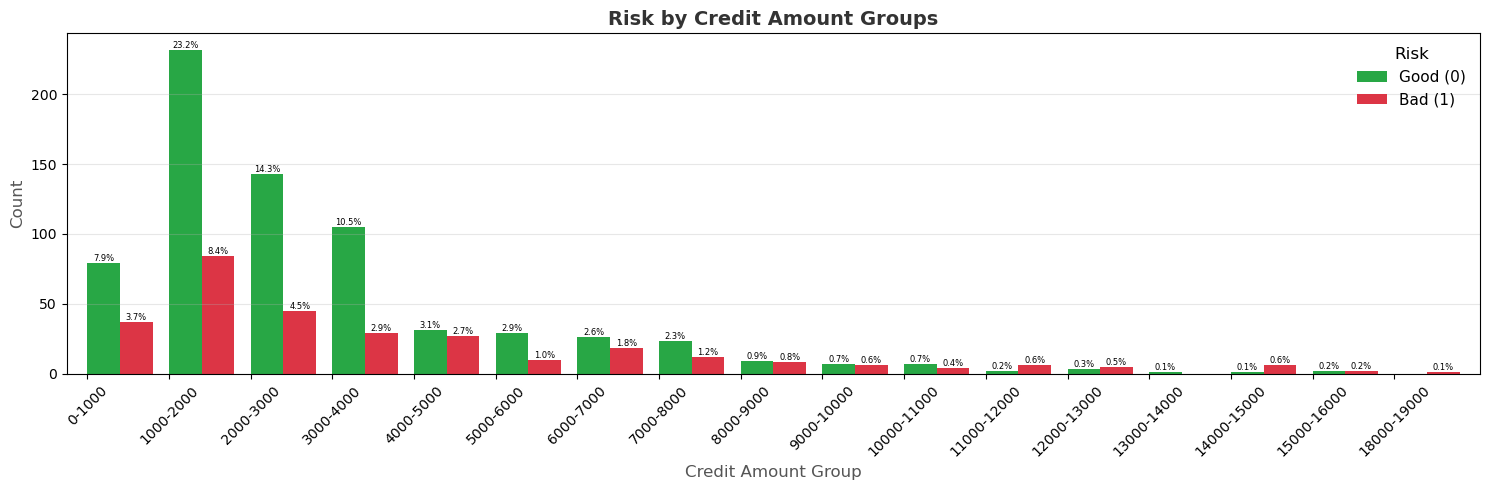

In [100]:
target_counts = pd.crosstab(df['cr_amount_group'], df['risk'])

fig, ax = plt.subplots(figsize=(15, 5))

colors_bar = ['#28a745', '#dc3545']  
bar_plot = target_counts.plot(kind='bar', ax=ax, color=colors_bar, width=0.8, position=0)

ax.set_title('Risk by Credit Amount Groups', fontsize=14, fontweight='bold', color='#333333')
ax.set_ylabel('Count', fontsize=12, color='#555555')
ax.set_xlabel('Credit Amount Group', fontsize=12, color='#555555')
ax.legend(['Good (0)', 'Bad (1)'], title='Risk', fontsize=11, loc='upper right', title_fontsize=12, frameon=False, handlelength=2)
ax.grid(True, axis='y', linestyle='-', alpha=0.3)

for p in bar_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height
    
    if height != 0:
        percentage = (height / target_counts.sum().sum()) * 100
        ax.text(x, y, f'{percentage:.1f}%', ha='center', va='bottom', color='black', fontsize=6, rotation=0)

ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


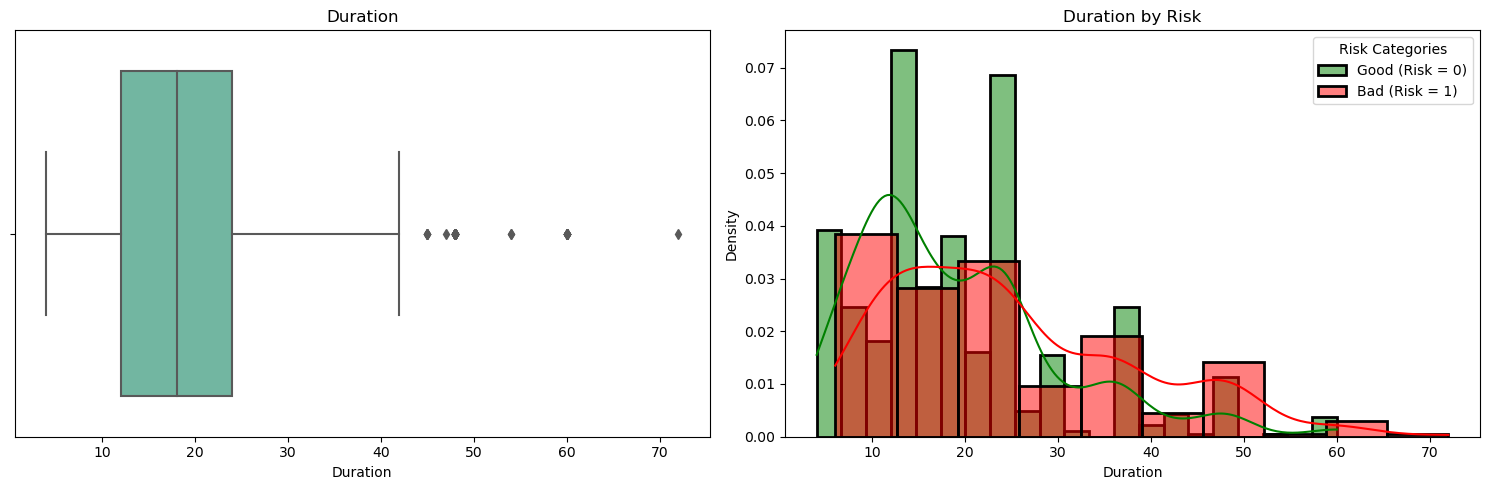

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=df, x='duration', orient='h', ax=axes[0], palette="Set2")
axes[0].set_title("Duration")
axes[0].set_xlabel("Duration")

sns.histplot(data=df[df['risk'] == 0], x='duration', kde=True, color='green', ax=axes[1], label='Good (Risk = 0)', stat="density", linewidth=2)
sns.histplot(data=df[df['risk'] == 1], x='duration', kde=True, color='red', ax=axes[1], label='Bad (Risk = 1)', stat="density", linewidth=2)
axes[1].set_title("Duration by Risk")
axes[1].set_xlabel("Duration")
axes[1].set_ylabel("Density")
axes[1].legend(title="Risk Categories")

plt.tight_layout()
plt.show()

In [102]:
bins_duration = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72]

labels_duration = ['4-8', '8-12', '12-16', '16-20', '20-24', '24-28', '28-32', '32-36', 
                   '36-40', '40-44', '44-48', '48-52', '52-56', '56-60', '60-64', '64-68', 
                   '68-72']

df['duration_group'] = pd.cut(df['duration'], bins=bins_duration, labels=labels_duration, right=True)

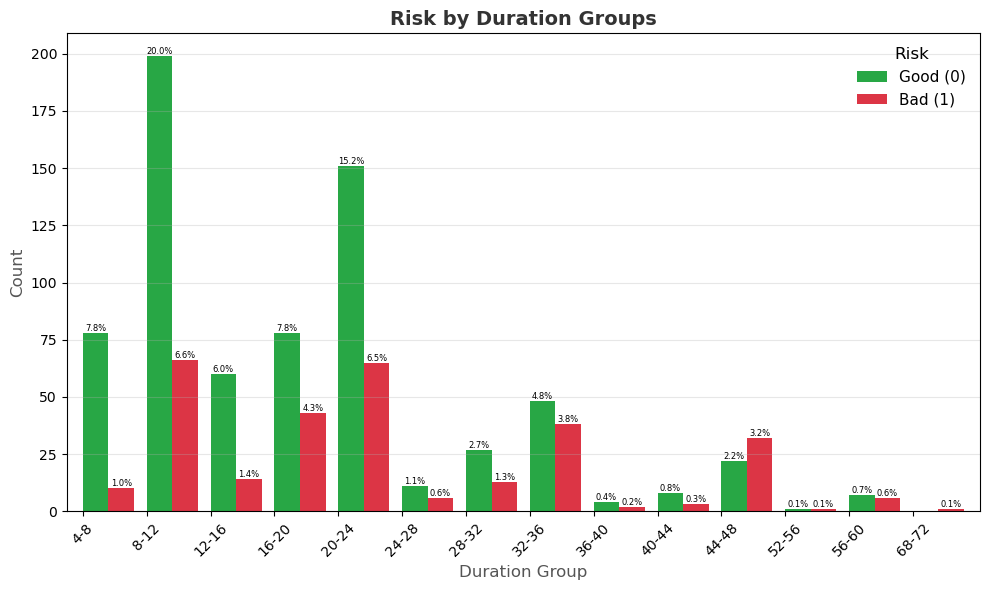

In [103]:
target_counts = pd.crosstab(df['duration_group'], df['risk'])

fig, ax = plt.subplots(figsize=(10, 6))

colors_bar = ['#28a745', '#dc3545']  
bar_plot = target_counts.plot(kind='bar', ax=ax, color=colors_bar, width=0.8, position=0)

ax.set_title('Risk by Duration Groups', fontsize=14, fontweight='bold', color='#333333')
ax.set_ylabel('Count', fontsize=12, color='#555555')
ax.set_xlabel('Duration Group', fontsize=12, color='#555555')
ax.legend(['Good (0)', 'Bad (1)'], title='Risk', fontsize=11, loc='upper right', title_fontsize=12, frameon=False, handlelength=2)
ax.grid(True, axis='y', linestyle='-', alpha=0.3)

for p in bar_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height
    
    if height != 0:
        percentage = (height / target_counts.sum().sum()) * 100
        ax.text(x, y, f'{percentage:.1f}%', ha='center', va='bottom', color='black', fontsize=6, rotation=0)

ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


## Data Preprocessing and Feature Engineering

In [11]:
ordinal_features = [
    'ca_status', 'cr_history', 'sav_acc', 'emp_status', 'job',
    'telephone', 'foreign_worker'
]
one_hot_features = [
    'purpose', 'sex_marriage', 'guarantors',
    'property', 'installment_plan', 'housing'
]
numeric_features = [
    'duration', 'cr_amount', 'installment_rate',
    'residence_duration', 'age', 'existing_cr', 'dependents'
]

ordinal_categories = [
    ['Negative balance', 'Low balance (<200 DM)', 'High balance (≥200 DM)', 'No account'],
    ['No/All paid back duly', 'All paid (same bank)', 'Existing credits paid back duly till now', 'Delayed payments', 'Multiple existing credits'],
    ['None / <100 DM', '100–500 DM', '500–1000 DM', '>1000 DM', 'Unknown/No Account'],
    ['Unemployed', '<1 year', '1–4 years', '4–7 years', '>7 years'],
    ['Un-employed/skilled NR', 'Unskilled R', 'Skilled', 'Management Employee'],
    ['No', 'Yes'],
    ['No', 'Yes']
]

ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)
onehot_encoder = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(transformers=[
    ('ord', ordinal_encoder, ordinal_features),
    ('ohe', onehot_encoder, one_hot_features),
    ('num', 'passthrough', numeric_features)
])

X = df.drop(columns='risk')
y = df['risk']

X = preprocessor.fit_transform(X)

ord_cols = ordinal_features
fitted_ohe = preprocessor.named_transformers_['ohe']
ohe_feature_names = fitted_ohe.get_feature_names_out(one_hot_features).tolist()
num_cols = numeric_features

final_feature_names = ord_cols + ohe_feature_names + num_cols
X = pd.DataFrame(X, columns=final_feature_names)
df = pd.concat([X, y.reset_index(drop=True)], axis=1)

In [12]:
df.shape

(1000, 36)

## Correlation Analysis

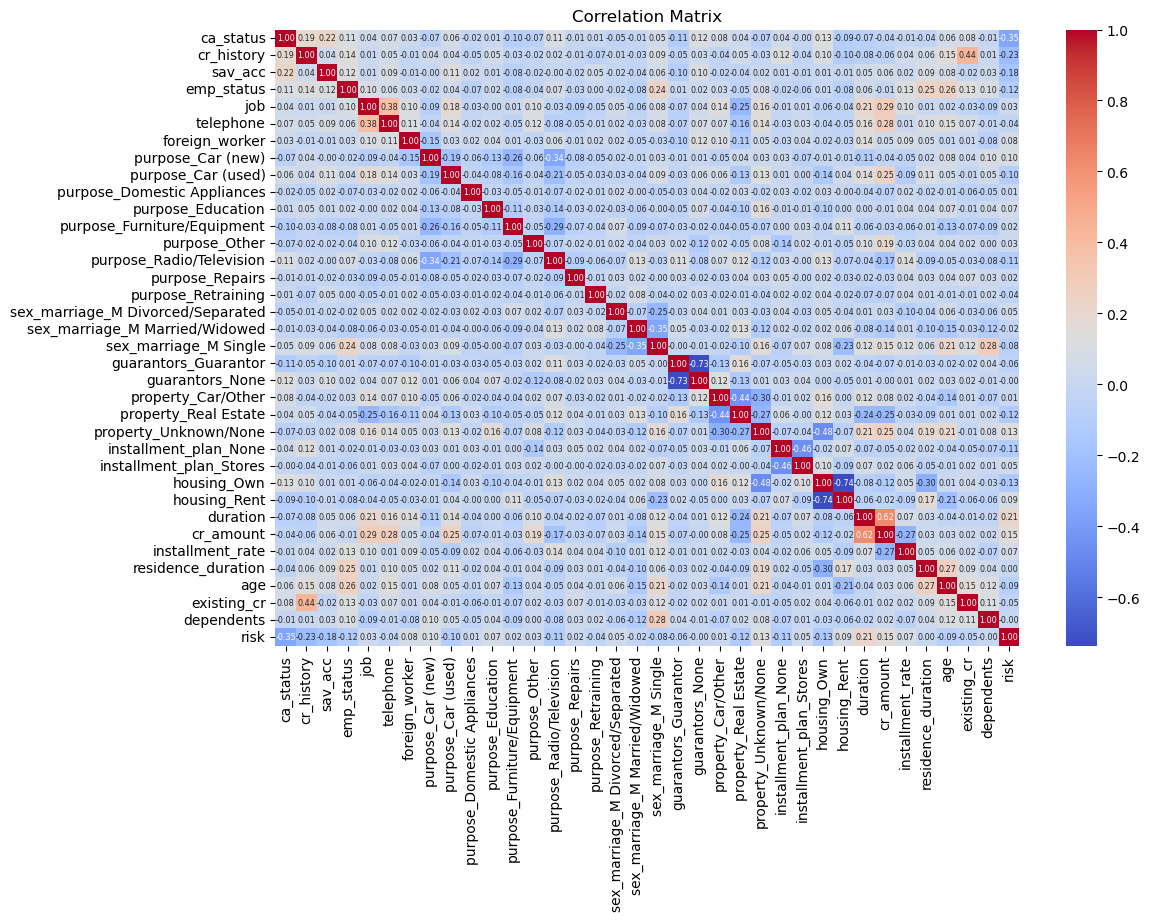

In [108]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 5.75})
plt.title('Correlation Matrix')
plt.show()

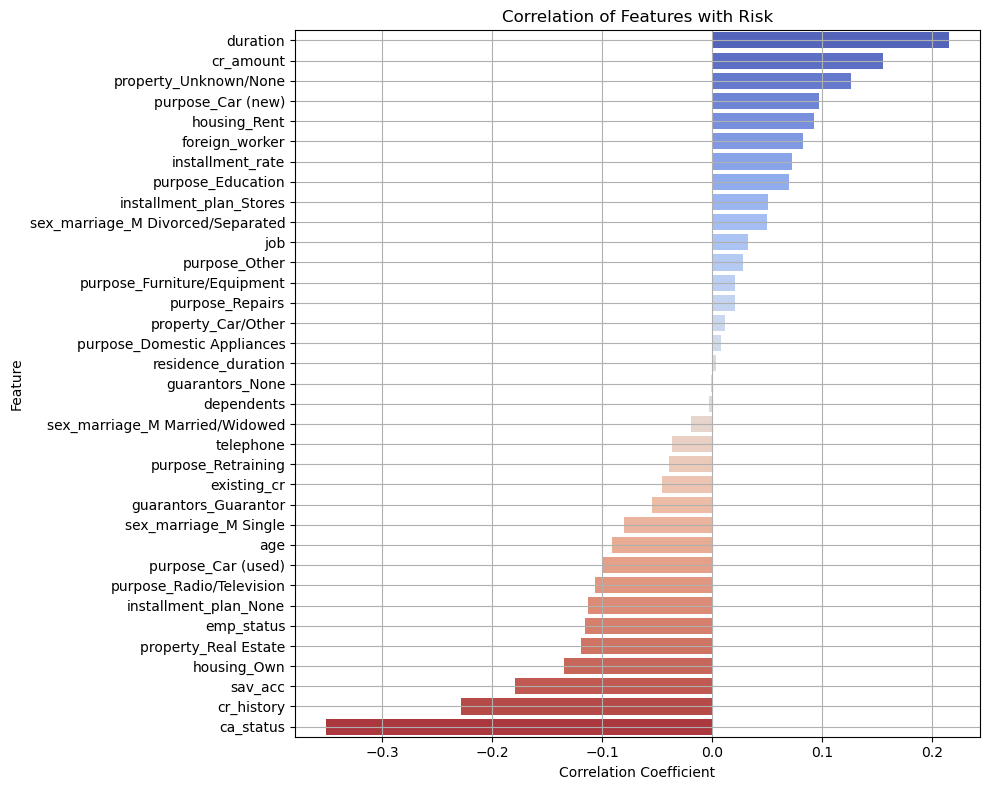

In [110]:
corr_matrix = df.corr(numeric_only=True)
risk_corr = corr_matrix['risk'].drop('risk').sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=risk_corr.values, y=risk_corr.index, palette='coolwarm')
plt.title('Correlation of Features with Risk')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()

## Train Test Split and Scaling

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=y)

In [14]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Logisitc Regression

In [15]:
def custom_cost(y_true, y_pred, fn_weight=5, fp_weight=1):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    cost = fn_weight * FN + fp_weight * FP
    return cost

In [19]:
model = LogisticRegression(random_state=42, max_iter=1000)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cost = custom_cost(y_test, y_pred)
print("\nCustom Cost (FN = 5 * FP):", cost)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

print("\nClassification Report:\n", classification_report(y_test, y_pred))


Custom Cost (FN = 5 * FP): 202

Confusion Matrix:
 [[153  22]
 [ 36  39]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       175
           1       0.64      0.52      0.57        75

    accuracy                           0.77       250
   macro avg       0.72      0.70      0.71       250
weighted avg       0.76      0.77      0.76       250



In [21]:
best_cost = cost
best_class_weights = None

for w_good in np.arange(0.1, 2.1, 0.1):
    for w_bad in np.arange(0.1, 2.1, 0.1):
        model = LogisticRegression(random_state=42, max_iter=1000, class_weight={0: w_good, 1: w_bad})
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        cost = custom_cost(y_test, y_pred)
        
        if cost < best_cost:
            best_cost = cost
            best_class_weights = {0: w_good, 1: w_bad}

print(f"\nBest class weights: {best_class_weights}")
print(f"Lowest custom cost: {best_cost}")

model = LogisticRegression(random_state=42, max_iter=1000, class_weight=best_class_weights)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cost = custom_cost(y_test, y_pred)
print("\nCustom Cost with Best Class Weights (FN = 5 * FP):", cost)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix with Best Class Weights:\n", conf_matrix)

print("\nClassification Report with Best Class Weights:\n", classification_report(y_test, y_pred))


Best class weights: {0: 0.1, 1: 0.30000000000000004}
Lowest custom cost: 115

Custom Cost with Best Class Weights (FN = 5 * FP): 115

Confusion Matrix with Best Class Weights:
 [[120  55]
 [ 12  63]]

Classification Report with Best Class Weights:
               precision    recall  f1-score   support

           0       0.91      0.69      0.78       175
           1       0.53      0.84      0.65        75

    accuracy                           0.73       250
   macro avg       0.72      0.76      0.72       250
weighted avg       0.80      0.73      0.74       250



In [22]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'tol' : [1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    'l1_ratio': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000,solver='saga',penalty='elasticnet',class_weight=best_class_weights),
    param_grid=param_grid,
    scoring=make_scorer(custom_cost, greater_is_better=False),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"\nBest Hyperparameters: {best_params}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

cost = custom_cost(y_test, y_pred)
print("\nCustom Cost after Hyperparameter Tuning (FN = 5 * FP):", cost)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix after Hyperparameter Tuning:\n", conf_matrix)

print("\nClassification Report after Hyperparameter Tuning:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 275 candidates, totalling 1375 fits

Best Hyperparameters: {'C': 1, 'l1_ratio': 0.6, 'tol': 0.1}

Custom Cost after Hyperparameter Tuning (FN = 5 * FP): 117

Confusion Matrix after Hyperparameter Tuning:
 [[113  62]
 [ 11  64]]

Classification Report after Hyperparameter Tuning:
               precision    recall  f1-score   support

           0       0.91      0.65      0.76       175
           1       0.51      0.85      0.64        75

    accuracy                           0.71       250
   macro avg       0.71      0.75      0.70       250
weighted avg       0.79      0.71      0.72       250



In [23]:
y_proba = best_model.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0, 1, 110)
costs = []

for t in thresholds:
    preds = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    total_cost = 5 * fn + fp
    costs.append(total_cost)

best_idx = np.argmin(costs)
best_threshold = thresholds[best_idx]
print(f"\nOptimal Threshold: {best_threshold:.2f} with Cost: {costs[best_idx]}")

y_pred_opt = (y_proba >= best_threshold).astype(int)

cost = custom_cost(y_test, y_pred_opt)
print("\nCustom Cost at Optimal Threshold (FN = 5 * FP):", cost)

conf_matrix_opt = confusion_matrix(y_test, y_pred_opt)
print("\nConfusion Matrix at Optimal Threshold:\n", conf_matrix_opt)

print("\nClassification Report at Optimal Threshold:\n", classification_report(y_test, y_pred_opt))



Optimal Threshold: 0.50 with Cost: 115

Custom Cost at Optimal Threshold (FN = 5 * FP): 115

Confusion Matrix at Optimal Threshold:
 [[115  60]
 [ 11  64]]

Classification Report at Optimal Threshold:
               precision    recall  f1-score   support

           0       0.91      0.66      0.76       175
           1       0.52      0.85      0.64        75

    accuracy                           0.72       250
   macro avg       0.71      0.76      0.70       250
weighted avg       0.79      0.72      0.73       250



## K-Nearest Neighbours Classifier

In [24]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cost = custom_cost(y_test, y_pred)
print("\nCustom Cost (FN = 5 * FP):", cost)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

print("\nClassification Report:\n", classification_report(y_test, y_pred))


Custom Cost (FN = 5 * FP): 268

Confusion Matrix:
 [[162  13]
 [ 51  24]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.93      0.84       175
           1       0.65      0.32      0.43        75

    accuracy                           0.74       250
   macro avg       0.70      0.62      0.63       250
weighted avg       0.73      0.74      0.71       250



In [25]:
best_cost = cost
best_params = None

for k in range(1, 21): 
    for metric in ['euclidean', 'manhattan']:
        model = KNeighborsClassifier(n_neighbors=k, metric=metric)
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        cost = custom_cost(y_test, y_pred)
        
        if cost < best_cost:
            best_cost = cost
            best_params = {'n_neighbors': k, 'metric': metric}

print(f"Best KNN Hyperparameters: {best_params}")
print(f"Lowest custom cost: {best_cost}")

model = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], metric=best_params['metric'])
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
cost = custom_cost(y_test, y_pred)
print("\nCustom Cost (FN = 5 * FP):", cost)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best KNN Hyperparameters: {'n_neighbors': 1, 'metric': 'euclidean'}
Lowest custom cost: 218

Custom Cost (FN = 5 * FP): 218

Confusion Matrix:
 [[137  38]
 [ 36  39]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.79       175
           1       0.51      0.52      0.51        75

    accuracy                           0.70       250
   macro avg       0.65      0.65      0.65       250
weighted avg       0.71      0.70      0.71       250



## Naive Bayes Classifier

In [27]:
model = GaussianNB()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cost = custom_cost(y_test, y_pred)
print("\nCustom Cost (FN = 5 * FP):", cost)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

print("\nClassification Report:\n", classification_report(y_test, y_pred))


Custom Cost (FN = 5 * FP): 197

Confusion Matrix:
 [[128  47]
 [ 30  45]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.73      0.77       175
           1       0.49      0.60      0.54        75

    accuracy                           0.69       250
   macro avg       0.65      0.67      0.65       250
weighted avg       0.71      0.69      0.70       250



In [28]:
best_cost = cost
best_alpha = None

for alpha in np.arange(0.0, 1.1, 0.1):
    model = GaussianNB(var_smoothing=alpha)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    cost = custom_cost(y_test, y_pred)
    
    if cost < best_cost:
        best_cost = cost
        best_alpha = alpha

print(f"Best Laplace smoothing parameter (alpha): {best_alpha}")
print(f"Lowest custom cost: {best_cost}")

model = GaussianNB(var_smoothing=best_alpha)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
cost = custom_cost(y_test, y_pred)
print("\nCustom Cost (FN = 5 * FP):", cost)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best Laplace smoothing parameter (alpha): 0.1
Lowest custom cost: 194

Custom Cost (FN = 5 * FP): 194

Confusion Matrix:
 [[131  44]
 [ 30  45]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.75      0.78       175
           1       0.51      0.60      0.55        75

    accuracy                           0.70       250
   macro avg       0.66      0.67      0.66       250
weighted avg       0.72      0.70      0.71       250



## Support Vector Classifier

In [29]:
model = SVC(random_state=42, probability=True)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cost = custom_cost(y_test, y_pred)
print("\nCustom Cost (FN = 5 * FP):", cost)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

print("\nClassification Report:\n", classification_report(y_test, y_pred))


Custom Cost (FN = 5 * FP): 234

Confusion Matrix:
 [[161  14]
 [ 44  31]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.92      0.85       175
           1       0.69      0.41      0.52        75

    accuracy                           0.77       250
   macro avg       0.74      0.67      0.68       250
weighted avg       0.76      0.77      0.75       250



In [30]:
best_cost = cost
best_class_weights = None

for w_good in np.arange(0.1, 2.1, 0.1):
    for w_bad in np.arange(0.1, 2.1, 0.1):
        model = SVC(random_state=42, probability=True, class_weight={0: w_good, 1: w_bad})
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        cost = custom_cost(y_test, y_pred)
        
        if cost < best_cost:
            best_cost = cost
            best_class_weights = {0: w_good, 1: w_bad}

print(f"\nBest class weights: {best_class_weights}")
print(f"Lowest custom cost: {best_cost}")

model = SVC(random_state=42, probability=True, class_weight=best_class_weights)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cost = custom_cost(y_test, y_pred)
print("\nCustom Cost with Best Class Weights (FN = 5 * FP):", cost)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix with Best Class Weights:\n", conf_matrix)

print("\nClassification Report with Best Class Weights:\n", classification_report(y_test, y_pred))


Best class weights: {0: 0.6, 1: 1.8000000000000003}
Lowest custom cost: 113

Custom Cost with Best Class Weights (FN = 5 * FP): 113

Confusion Matrix with Best Class Weights:
 [[127  48]
 [ 13  62]]

Classification Report with Best Class Weights:
               precision    recall  f1-score   support

           0       0.91      0.73      0.81       175
           1       0.56      0.83      0.67        75

    accuracy                           0.76       250
   macro avg       0.74      0.78      0.74       250
weighted avg       0.80      0.76      0.77       250



In [31]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=SVC(random_state=42, probability=True,class_weight=best_class_weights),
    param_grid=param_grid,
    scoring=make_scorer(custom_cost, greater_is_better=False),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"\nBest Hyperparameters: {best_params}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

cost = custom_cost(y_test, y_pred)
print("\nCustom Cost after Hyperparameter Tuning (FN = 5 * FP):", cost)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix after Hyperparameter Tuning:\n", conf_matrix)

print("\nClassification Report after Hyperparameter Tuning:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best Hyperparameters: {'C': 0.01, 'kernel': 'linear'}

Custom Cost after Hyperparameter Tuning (FN = 5 * FP): 117

Confusion Matrix after Hyperparameter Tuning:
 [[118  57]
 [ 12  63]]

Classification Report after Hyperparameter Tuning:
               precision    recall  f1-score   support

           0       0.91      0.67      0.77       175
           1       0.53      0.84      0.65        75

    accuracy                           0.72       250
   macro avg       0.72      0.76      0.71       250
weighted avg       0.79      0.72      0.74       250



In [32]:
y_proba = best_model.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0, 1, 110)
costs = []

for t in thresholds:
    preds = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    total_cost = 5 * fn + fp
    costs.append(total_cost)

best_idx = np.argmin(costs)
best_threshold = thresholds[best_idx]
print(f"\nOptimal Threshold: {best_threshold:.2f} with Cost: {costs[best_idx]}")

y_pred_opt = (y_proba >= best_threshold).astype(int)

cost = custom_cost(y_test, y_pred_opt)
print("\nCustom Cost at Optimal Threshold (FN = 5 * FP):", cost)

conf_matrix_opt = confusion_matrix(y_test, y_pred_opt)
print("\nConfusion Matrix at Optimal Threshold:\n", conf_matrix_opt)

print("\nClassification Report at Optimal Threshold:\n", classification_report(y_test, y_pred_opt))


Optimal Threshold: 0.27 with Cost: 115

Custom Cost at Optimal Threshold (FN = 5 * FP): 115

Confusion Matrix at Optimal Threshold:
 [[120  55]
 [ 12  63]]

Classification Report at Optimal Threshold:
               precision    recall  f1-score   support

           0       0.91      0.69      0.78       175
           1       0.53      0.84      0.65        75

    accuracy                           0.73       250
   macro avg       0.72      0.76      0.72       250
weighted avg       0.80      0.73      0.74       250



## Decision Tree Classifier

In [33]:
model = DecisionTreeClassifier(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cost = custom_cost(y_test, y_pred)
print("\nCustom Cost (FN = 5 * FP):", cost)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

print("\nClassification Report:\n", classification_report(y_test, y_pred))


Custom Cost (FN = 5 * FP): 224

Confusion Matrix:
 [[141  34]
 [ 38  37]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80       175
           1       0.52      0.49      0.51        75

    accuracy                           0.71       250
   macro avg       0.65      0.65      0.65       250
weighted avg       0.71      0.71      0.71       250



In [34]:
best_cost = cost
best_class_weights = None

for w_good in np.arange(0.1, 2.1, 0.1):
    for w_bad in np.arange(0.1, 2.1, 0.1):
        model = DecisionTreeClassifier(random_state=42, class_weight={0: w_good, 1: w_bad})
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        cost = custom_cost(y_test, y_pred)
        
        if cost < best_cost:
            best_cost = cost
            best_class_weights = {0: w_good, 1: w_bad}

print(f"\nBest class weights: {best_class_weights}")
print(f"Lowest custom cost: {best_cost}")

model = DecisionTreeClassifier(random_state=42, class_weight=best_class_weights)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cost = custom_cost(y_test, y_pred)
print("\nCustom Cost with Best Class Weights (FN = 5 * FP):", cost)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix with Best Class Weights:\n", conf_matrix)

print("\nClassification Report with Best Class Weights:\n", classification_report(y_test, y_pred))


Best class weights: {0: 0.7000000000000001, 1: 0.9}
Lowest custom cost: 182

Custom Cost with Best Class Weights (FN = 5 * FP): 182

Confusion Matrix with Best Class Weights:
 [[138  37]
 [ 29  46]]

Classification Report with Best Class Weights:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81       175
           1       0.55      0.61      0.58        75

    accuracy                           0.74       250
   macro avg       0.69      0.70      0.69       250
weighted avg       0.74      0.74      0.74       250



In [35]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42,class_weight=best_class_weights),
    param_grid=param_grid,
    scoring=make_scorer(custom_cost, greater_is_better=False),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"\nBest Hyperparameters: {best_params}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

cost = custom_cost(y_test, y_pred)
print("\nCustom Cost after Hyperparameter Tuning (FN = 5 * FP):", cost)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix after Hyperparameter Tuning:\n", conf_matrix)

print("\nClassification Report after Hyperparameter Tuning:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

Custom Cost after Hyperparameter Tuning (FN = 5 * FP): 167

Confusion Matrix after Hyperparameter Tuning:
 [[138  37]
 [ 26  49]]

Classification Report after Hyperparameter Tuning:
               precision    recall  f1-score   support

           0       0.84      0.79      0.81       175
           1       0.57      0.65      0.61        75

    accuracy                           0.75       250
   macro avg       0.71      0.72      0.71       250
weighted avg       0.76      0.75      0.75       250



In [36]:
y_proba = best_model.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0, 1, 110)
costs = []

for t in thresholds:
    preds = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    total_cost = 5 * fn + fp
    costs.append(total_cost)

best_idx = np.argmin(costs)
best_threshold = thresholds[best_idx]
print(f"\nOptimal Threshold: {best_threshold:.2f} with Cost: {costs[best_idx]}")

y_pred_opt = (y_proba >= best_threshold).astype(int)

cost = custom_cost(y_test, y_pred_opt)
print("\nCustom Cost at Optimal Threshold (FN = 5 * FP):", cost)

conf_matrix_opt = confusion_matrix(y_test, y_pred_opt)
print("\nConfusion Matrix at Optimal Threshold:\n", conf_matrix_opt)

print("\nClassification Report at Optimal Threshold:\n", classification_report(y_test, y_pred_opt))


Optimal Threshold: 0.14 with Cost: 132

Custom Cost at Optimal Threshold (FN = 5 * FP): 132

Confusion Matrix at Optimal Threshold:
 [[93 82]
 [10 65]]

Classification Report at Optimal Threshold:
               precision    recall  f1-score   support

           0       0.90      0.53      0.67       175
           1       0.44      0.87      0.59        75

    accuracy                           0.63       250
   macro avg       0.67      0.70      0.63       250
weighted avg       0.76      0.63      0.64       250



## Random Forest Classifier

In [63]:
model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cost = custom_cost(y_test, y_pred)
print("\nCustom Cost (FN = 5 * FP):", cost)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

print("\nClassification Report:\n", classification_report(y_test, y_pred))


Custom Cost (FN = 5 * FP): 217

Confusion Matrix:
 [[158  17]
 [ 40  35]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.90      0.85       175
           1       0.67      0.47      0.55        75

    accuracy                           0.77       250
   macro avg       0.74      0.68      0.70       250
weighted avg       0.76      0.77      0.76       250



In [64]:
best_cost = cost
best_class_weights = None

for w_good in np.arange(0.1, 2.1, 0.1):
    for w_bad in np.arange(0.1, 2.1, 0.1):
        model = RandomForestClassifier(random_state=42, class_weight={0: w_good, 1: w_bad})
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        cost = custom_cost(y_test, y_pred)
        
        if cost < best_cost:
            best_cost = cost
            best_class_weights = {0: w_good, 1: w_bad}

print(f"\nBest class weights: {best_class_weights}")
print(f"Lowest custom cost: {best_cost}")

model = RandomForestClassifier(random_state=42, class_weight=best_class_weights)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cost = custom_cost(y_test, y_pred)
print("\nCustom Cost with Best Class Weights (FN = 5 * FP):", cost)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix with Best Class Weights:\n", conf_matrix)

print("\nClassification Report with Best Class Weights:\n", classification_report(y_test, y_pred))


Best class weights: {0: 2.0, 1: 1.1}
Lowest custom cost: 191

Custom Cost with Best Class Weights (FN = 5 * FP): 191

Confusion Matrix with Best Class Weights:
 [[164  11]
 [ 36  39]]

Classification Report with Best Class Weights:
               precision    recall  f1-score   support

           0       0.82      0.94      0.87       175
           1       0.78      0.52      0.62        75

    accuracy                           0.81       250
   macro avg       0.80      0.73      0.75       250
weighted avg       0.81      0.81      0.80       250



In [65]:
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced', best_class_weights],
    'bootstrap': [True], 
    'max_features': ['sqrt', 'log2'], 
    'max_samples': [None, 0.5, 0.8]  
}

grid_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,
    scoring=make_scorer(custom_cost, greater_is_better=False),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=2,
    random_state=42,error_score='raise'
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"\nBest Hyperparameters: {best_params}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

cost = custom_cost(y_test, y_pred)
print("\nCustom Cost after Hyperparameter Tuning (FN = 5 * FP):", cost)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix after Hyperparameter Tuning:\n", conf_matrix)

print("\nClassification Report after Hyperparameter Tuning:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.5, 'max_features': 'log2', 'max_depth': 3, 'class_weight': 'balanced', 'bootstrap': True}

Custom Cost after Hyperparameter Tuning (FN = 5 * FP): 161

Confusion Matrix after Hyperparameter Tuning:
 [[129  46]
 [ 23  52]]

Classification Report after Hyperparameter Tuning:
               precision    recall  f1-score   support

           0       0.85      0.74      0.79       175
           1       0.53      0.69      0.60        75

    accuracy                           0.72       250
   macro avg       0.69      0.72      0.70       250
weighted avg       0.75      0.72      0.73       250



In [66]:
y_proba = best_model.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0, 1, 110)
costs = []

for t in thresholds:
    preds = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    total_cost = 5 * fn + fp
    costs.append(total_cost)

best_idx = np.argmin(costs)
best_threshold = thresholds[best_idx]
print(f"\nOptimal Threshold: {best_threshold:.2f} with Cost: {costs[best_idx]}")

y_pred_opt = (y_proba >= best_threshold).astype(int)

cost = custom_cost(y_test, y_pred_opt)
print("\nCustom Cost at Optimal Threshold (FN = 5 * FP):", cost)

conf_matrix_opt = confusion_matrix(y_test, y_pred_opt)
print("\nConfusion Matrix at Optimal Threshold:\n", conf_matrix_opt)

print("\nClassification Report at Optimal Threshold:\n", classification_report(y_test, y_pred_opt))


Optimal Threshold: 0.40 with Cost: 129

Custom Cost at Optimal Threshold (FN = 5 * FP): 129

Confusion Matrix at Optimal Threshold:
 [[76 99]
 [ 6 69]]

Classification Report at Optimal Threshold:
               precision    recall  f1-score   support

           0       0.93      0.43      0.59       175
           1       0.41      0.92      0.57        75

    accuracy                           0.58       250
   macro avg       0.67      0.68      0.58       250
weighted avg       0.77      0.58      0.58       250



## Gradient Boosting Classifier

In [67]:
model = GradientBoostingClassifier(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cost = custom_cost(y_test, y_pred)
print("\nCustom Cost (FN = 5 * FP):", cost)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

print("\nClassification Report:\n", classification_report(y_test, y_pred))


Custom Cost (FN = 5 * FP): 183

Confusion Matrix:
 [[157  18]
 [ 33  42]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86       175
           1       0.70      0.56      0.62        75

    accuracy                           0.80       250
   macro avg       0.76      0.73      0.74       250
weighted avg       0.79      0.80      0.79       250



In [68]:
param_dist = {
    'n_estimators': np.arange(50, 301, 50),
    'max_depth': np.arange(3, 11, 1),
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

random_search = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,
    scoring=make_scorer(custom_cost, greater_is_better=False),
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print(f"\nBest Hyperparameters: {best_params}")

best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

cost = custom_cost(y_test, y_pred)
print("\nCustom Cost (FN = 5 * FP):", cost)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

y_proba = best_model.predict_proba(X_test)[:, 1]

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 3, 'learning_rate': 0.1}

Custom Cost (FN = 5 * FP): 185

Confusion Matrix:
 [[155  20]
 [ 33  42]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       175
           1       0.68      0.56      0.61        75

    accuracy                           0.79       250
   macro avg       0.75      0.72      0.73       250
weighted avg       0.78      0.79      0.78       250



In [69]:
thresholds = np.linspace(0, 1, 110)
costs = []

for t in thresholds:
    preds = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    total_cost = 5 * fn + fp
    costs.append(total_cost)

best_idx = np.argmin(costs)
best_threshold = thresholds[best_idx]
print(f"\nOptimal Threshold: {best_threshold:.2f} with Cost: {costs[best_idx]}")

y_pred_opt = (y_proba >= best_threshold).astype(int)

cost = custom_cost(y_test, y_pred_opt)
print("\nCustom Cost at Optimal Threshold (FN = 5 * FP):", cost)

conf_matrix_opt = confusion_matrix(y_test, y_pred_opt)
print("\nConfusion Matrix at Optimal Threshold:\n", conf_matrix_opt)

print("\nClassification Report at Optimal Threshold:\n", classification_report(y_test, y_pred_opt))


Optimal Threshold: 0.14 with Cost: 129

Custom Cost at Optimal Threshold (FN = 5 * FP): 129

Confusion Matrix at Optimal Threshold:
 [[101  74]
 [ 11  64]]

Classification Report at Optimal Threshold:
               precision    recall  f1-score   support

           0       0.90      0.58      0.70       175
           1       0.46      0.85      0.60        75

    accuracy                           0.66       250
   macro avg       0.68      0.72      0.65       250
weighted avg       0.77      0.66      0.67       250



## XGB Classifier

In [70]:
def custom_cost(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    cost = 5 * fn + fp
    return cost

model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cost = custom_cost(y_test, y_pred)
print("\nCustom Cost (FN = 5 * FP):", cost)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

print("\nClassification Report:\n", classification_report(y_test, y_pred))


Custom Cost (FN = 5 * FP): 187

Confusion Matrix:
 [[158  17]
 [ 34  41]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       175
           1       0.71      0.55      0.62        75

    accuracy                           0.80       250
   macro avg       0.76      0.72      0.74       250
weighted avg       0.79      0.80      0.79       250



In [71]:
param_dist = {
    'n_estimators': np.arange(50, 301, 50),
    'max_depth': np.arange(3, 11, 1),
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5],
    'subsample': [0.7, 0.8, 0.9, 1.0], 
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0], 
}

random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', random_state=42),
    param_distributions=param_dist,
    n_iter=50, 
    scoring=make_scorer(custom_cost, greater_is_better=False),
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print(f"\nBest Hyperparameters: {best_params}")

best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

cost = custom_cost(y_test, y_pred)
print("\nCustom Cost (FN = 5 * FP):", cost)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.5, 'colsample_bytree': 1.0}

Custom Cost (FN = 5 * FP): 182

Confusion Matrix:
 [[153  22]
 [ 32  43]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       175
           1       0.66      0.57      0.61        75

    accuracy                           0.78       250
   macro avg       0.74      0.72      0.73       250
weighted avg       0.78      0.78      0.78       250



In [ ]:
y_proba = best_model.predict_proba(X_test)[:, 1]  

thresholds = np.linspace(0, 1, 110)
costs = []

for t in thresholds:
    preds = (y_proba >= t).astype(int) 
    cost = custom_cost(y_test, preds)
    costs.append(cost)

best_idx = np.argmin(costs)
best_threshold = thresholds[best_idx]
print(f"\nOptimal Threshold: {best_threshold:.2f} with Cost: {costs[best_idx]}")

y_pred_opt = (y_proba >= best_threshold).astype(int)

cost = custom_cost(y_test, y_pred_opt)
print("\nCustom Cost at Optimal Threshold (FN = 5 * FP):", cost)

conf_matrix_opt = confusion_matrix(y_test, y_pred_opt)
print("\nConfusion Matrix at Optimal Threshold:\n", conf_matrix_opt)

print("\nClassification Report at Optimal Threshold:\n", classification_report(y_test, y_pred_opt))


Optimal Threshold: 0.04 with Cost: 117

Custom Cost at Optimal Threshold (FN = 5 * FP): 117

Confusion Matrix at Optimal Threshold:
 [[98 77]
 [ 8 67]]

Classification Report at Optimal Threshold:
               precision    recall  f1-score   support

           0       0.92      0.56      0.70       175
           1       0.47      0.89      0.61        75

    accuracy                           0.66       250
   macro avg       0.69      0.73      0.65       250
weighted avg       0.79      0.66      0.67       250

